In [1144]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import csv
import datetime
import itertools
import os
import pandas as pd
import statistics
import statistics
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import skew
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import savgol_filter
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATConv


## contents

1. [Pre-GNN Evaluation of Trial Data](#1)

    1.1 [LDA](#1.1)
    
    1.2 [ROC CURVES](#1.2)
        
2. [Pre-GNN Consolidated Weekly Graphs of Observational Data](#2)


3. [GNN](#3)


4. [Post-GNN Evaluation of Trial Data](#4)

    4.1 [LDA](#4.1)
    
    4.2 [ROC CURVES](#4.2)

5. [Pre-GNN Consolidated Weekly Graphs of Observational Data](#5)


# 1. Pre-GNN Evaluation of Trial Data <a class="anchor" id="1"></a>


### 1. LDA <a class="anchor" id="1.1"></a>


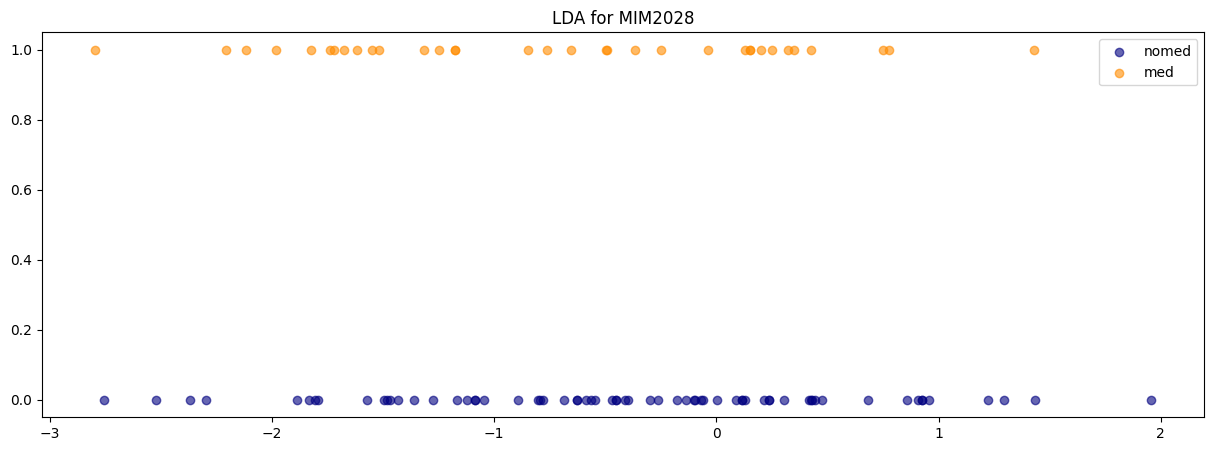

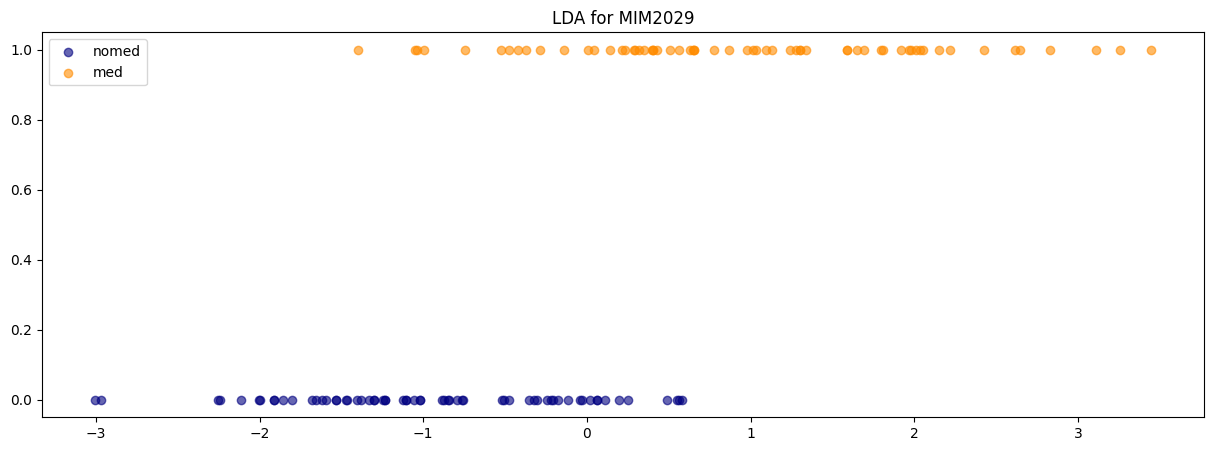

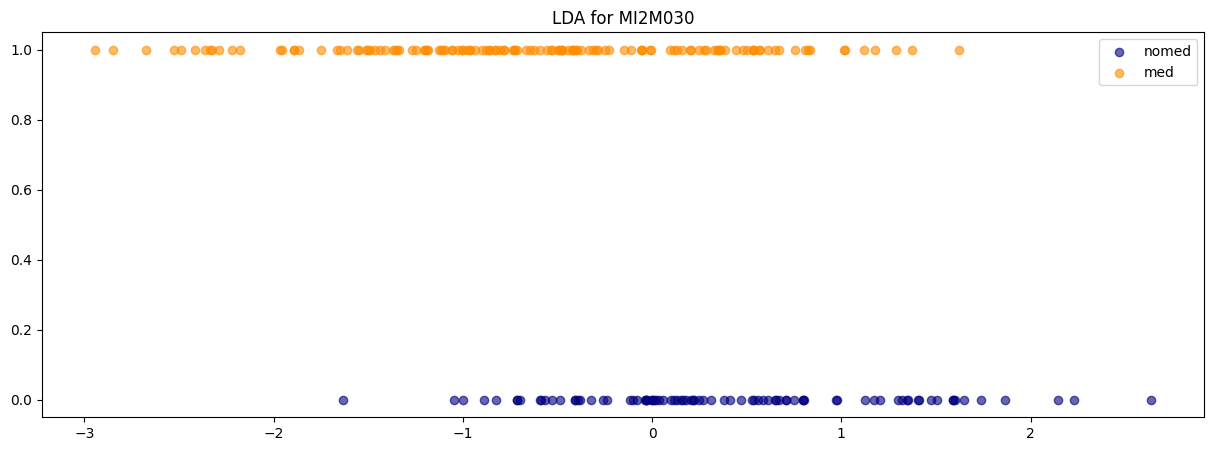

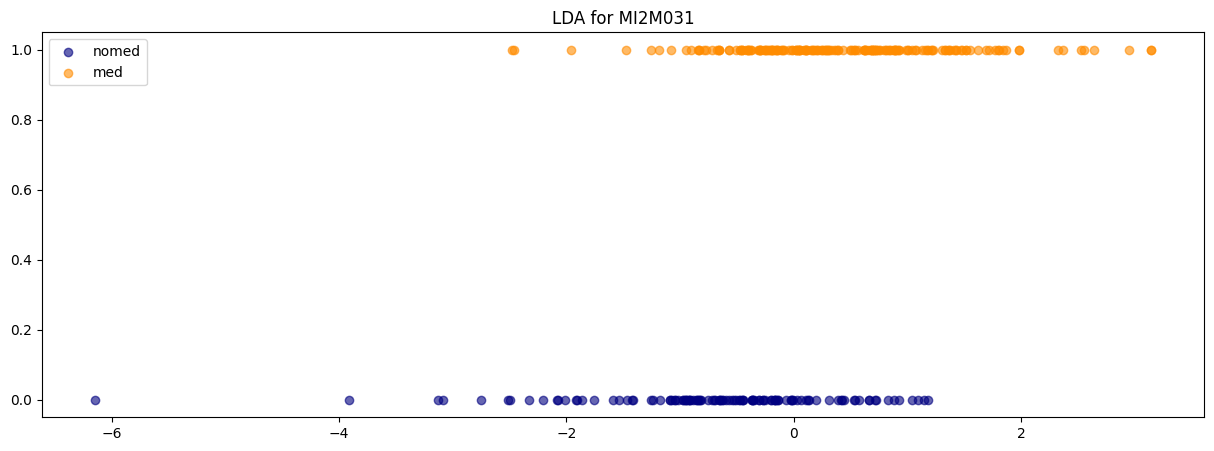

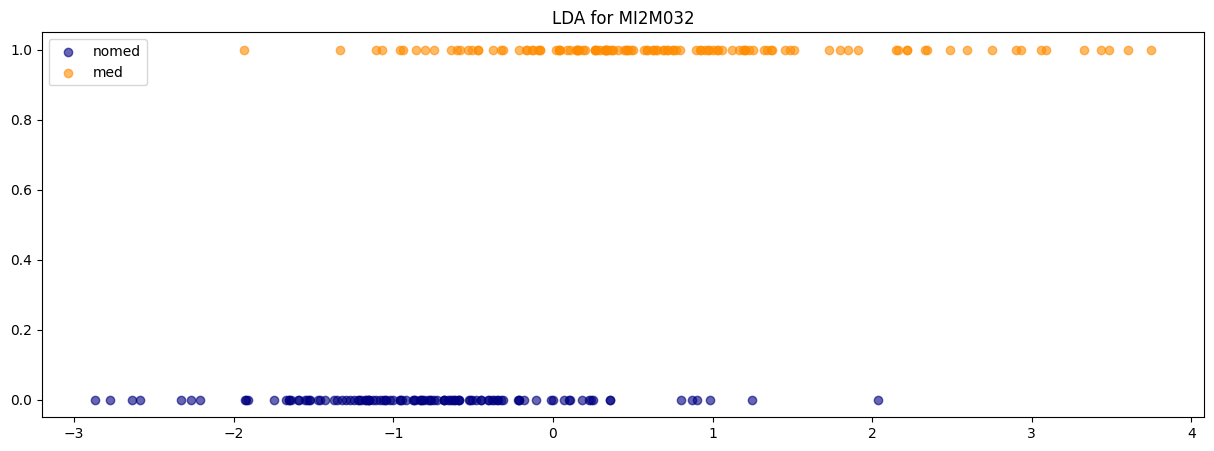

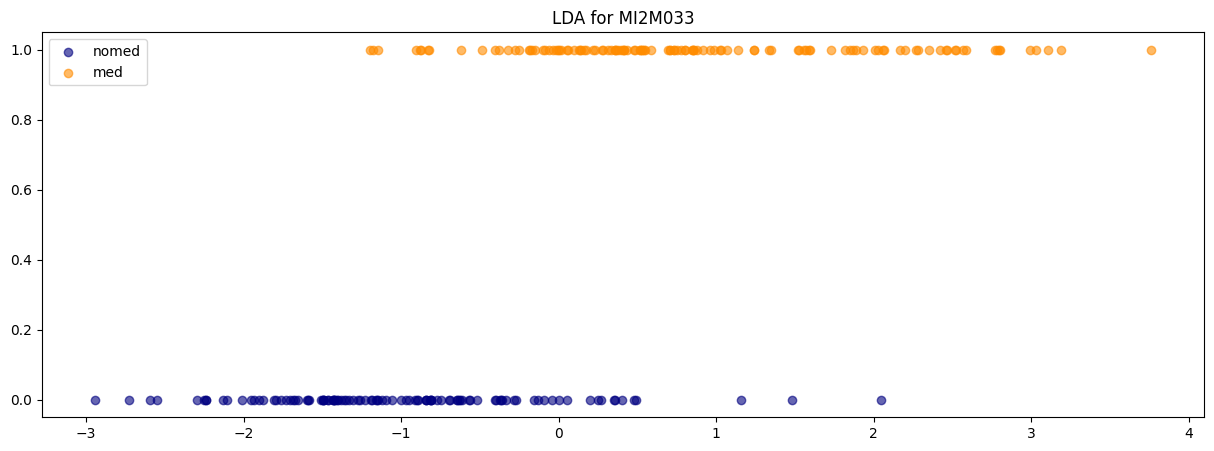

In [740]:
trial_data = pd.read_csv("trial_data.csv")
unique_users = trial_data['user'].unique()

for user in unique_users:
    med_status = {"nomed": 0,"med": 1}
    windowed_data = trial_data[trial_data['user'] == user]
    windowed_data = windowed_data.drop(['time_bin_start','user'],axis=1)
    windowed_data.rename(columns={'med':'target'}, inplace=True)
    X_train = windowed_data.drop(['target'],axis=1).reset_index()
    Y_train = windowed_data['target'].reset_index()
    optional_med_status = np.array([0,1])
    if optional_med_status.shape[0] == 2:
        lda_dim = 1
    elif optional_med_status.shape[0] < 2:
        print('fail: not enough status for med analysis')
    else:
        lda_dim = 2
    X_train = X_train.drop(['index'],axis=1)
    X_r = X_train.values
    y   = Y_train['target'].values
    target_names = np.array(["nomed", "med"])
    
    
    if lda_dim == 2:
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        df = pd.DataFrame({'lda_value1':X_r2[:,0],'lda_value2':X_r2[:,1],'Label':y})
    
        colors = ["navy", "darkorange","cyan"]
        plt.figure()
        for color, i, target_name in zip(colors, list(optional_med_status), target_names):
            plt.scatter(
                X_r2[y == i,0], X_r2[y == i,1], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA all states")
        plt.savefig(save_path + 'lda.png')
        plt.show()
        
        sil_score = []
        p_value   = []
        x1 = X_train.values[y==0]
        for stat in optional_med_status:
            if stat ==0:
                continue
            x2 = X_train.values[y==stat]
            x3 = np.concatenate((x1,x2),axis=0)
            sil_score.append(metrics.silhouette_score(x3,lda.predict(x3),metric='euclidean'))
            p_value.append(stats.ttest_ind(a=X_r2[y==0,0],b=X_r2[y==i,0],equal_var=False))
            
        X_r = X_train.values
        y   = Y_train['target'].values
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        without_center = [X_r2[y == 0,0].mean(), X_r2[y == 0,1].mean()]
        colors = ["darkorange",'cyan']
        plt.figure()
        for color, i, target_name in zip(colors, [1,2], target_names[1:]):
            plt.scatter(
                X_r2[y == i,0] - without_center[0], X_r2[y == i,1] - without_center[1], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA Aligned")
        plt.show()
        
        with1 = X_r2[y == 1][:,0].mean()
        with2 = X_r2[y == 2][:,0].mean()
        without = X_r2[y == 0][:,0].mean()
        colors = ['navy',"darkorange",'cyan']
        for color, i, target_name in zip(colors, [0,1,2], target_names):
            plt.scatter(
                X_r2[y == i][:,0].mean(), X_r2[y == i][:,0].mean(), alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA Aggregate")
        plt.show()
    
    plt.rcParams['figure.figsize'] = [15, 5]
    
    if lda_dim == 1:
        lda = LinearDiscriminantAnalysis(n_components=1)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        df = pd.DataFrame({'lda_value':X_r2[:,0],'Label':y})
        colors = ["navy", "darkorange"]
        plt.figure()
        for color, i, target_name in zip(colors, list(optional_med_status), target_names):
            plt.scatter(
                X_r2[y == i], y[y==i], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title(f"LDA for {user}")
        #plt.savefig(save_path + 'lda.png')
        plt.show()


### 1.2. ROC CURVE <a class="anchor" id="1.2"></a>


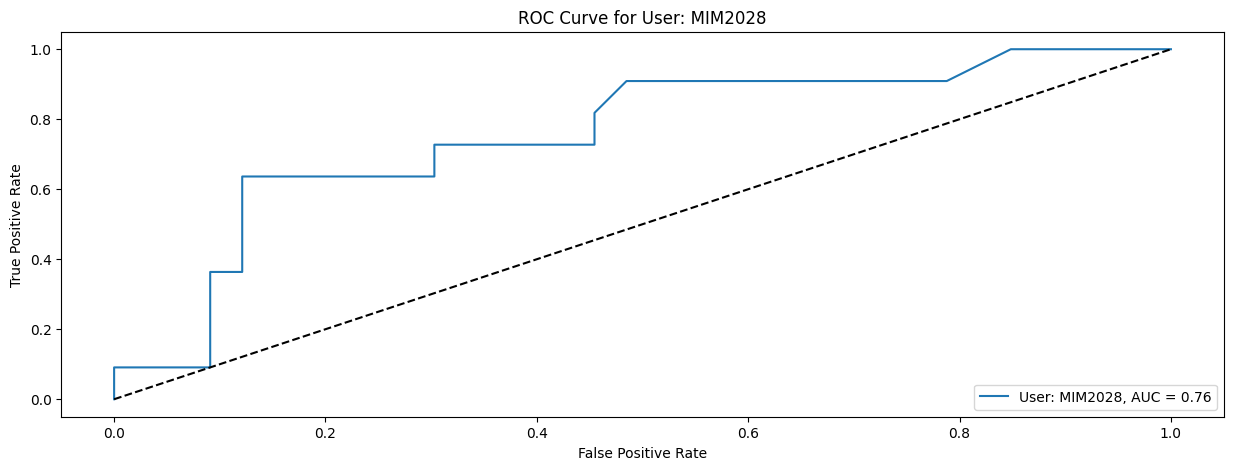

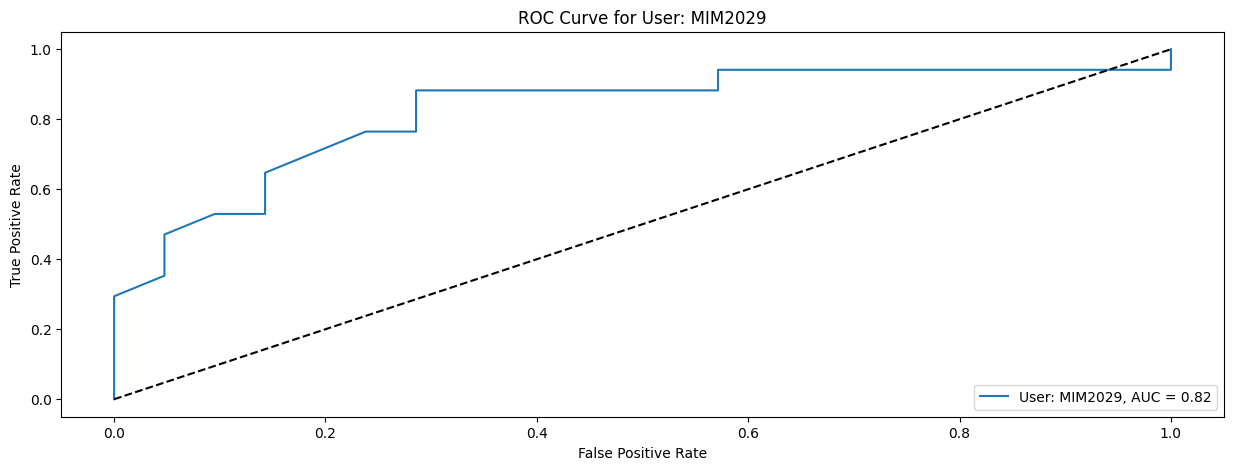

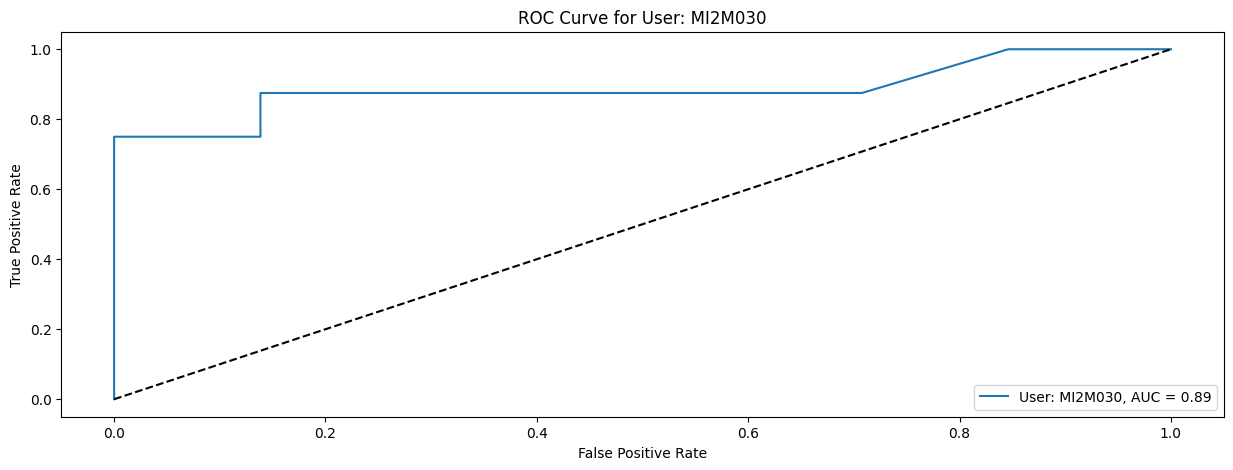

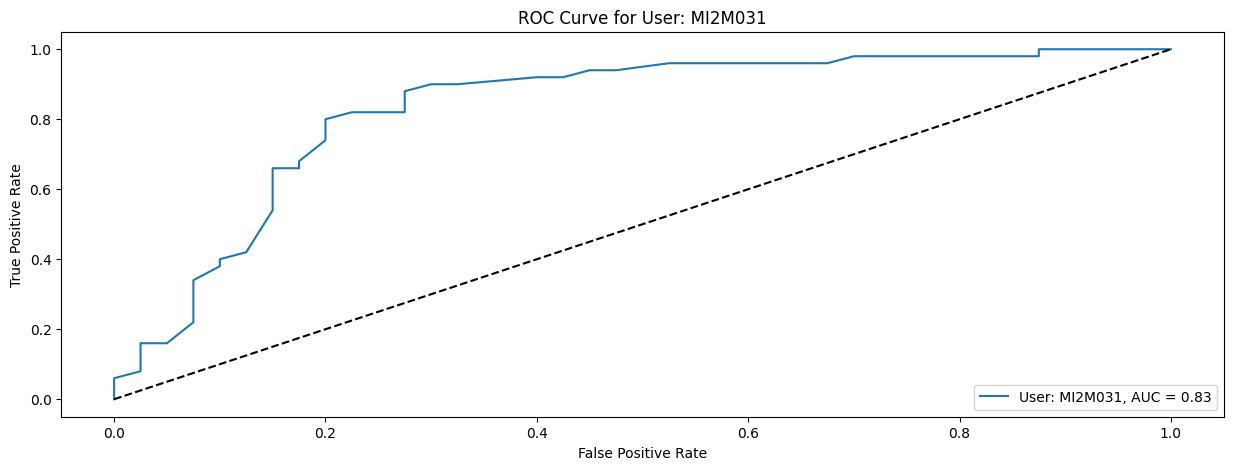

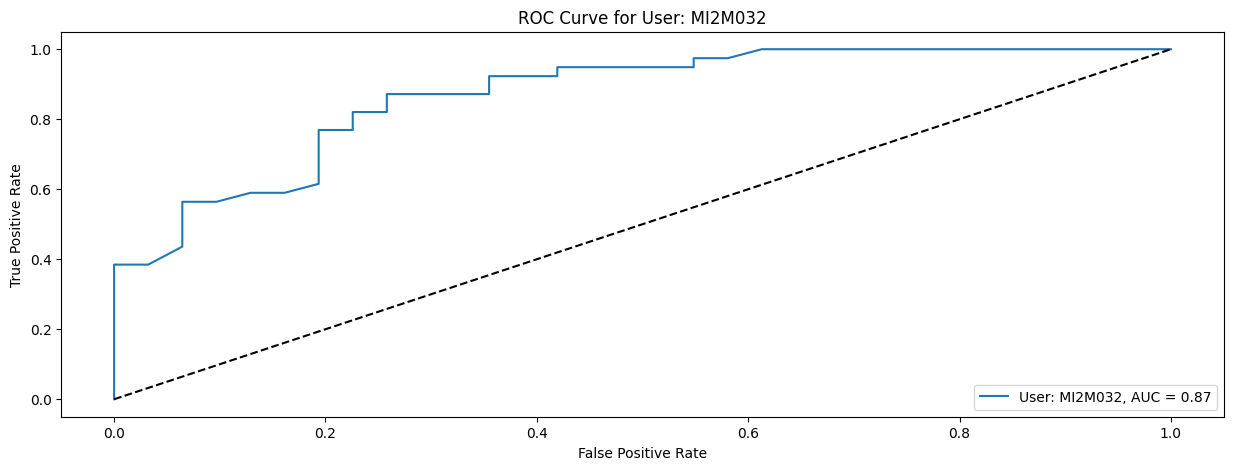

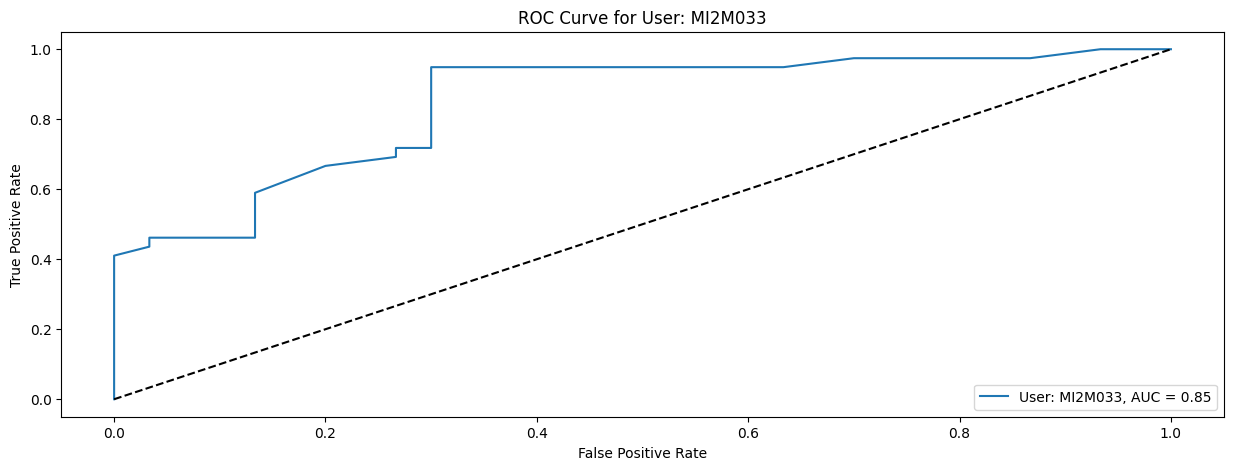

In [741]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

windowed_data = pd.read_csv('trial_data.csv')
unique_users = windowed_data['user'].unique()

for user in unique_users:
    user_data = windowed_data[windowed_data['user'] == user].copy()
    user_data = user_data.drop(['time_bin_start', 'user'], axis=1)

# Convert 'med' to binary if necessary - in our trial, a high dose (med=2) indicates that the physician deemed the regular dose (med=1) insufficiently effective.
    if user_data['med'].nunique() == 3:
        user_data['med'] = user_data['med'].replace({1: 0, 2: 1})

    # Split the data into features and target
    X = user_data.drop('med', axis=1)
    y = user_data['med']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a simple Random Forest model
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the AUC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'User: {user}, AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for User: {user}')
    plt.legend(loc='lower right')
    plt.show()


# 2. Pre-GNN Consolidated Weekly Graphs of Observational Data <a class="anchor" id="2"></a>


In [742]:
users_daily = pd.read_csv('users_daily.csv')
users_daily

,time_since_med,x_mean,y_mean,z_mean,x_std,y_std,z_std,rms,rec_num_acc,gx_mean,...,gy_zcr,gz_zcr,g_rms,rec_num_gyro,hrv_mean,hrv_std,rec_num_hrv,user,day,date
0,1.072683,-1.498744,-9.448413,0.772515,0.830578,0.973898,3.342419,5.541225,737,0.036052,...,0.431193,0.458716,0.039299,110,111.894697,47.386745,21,yaron_week1,1,2.05
1,1.097683,0.703077,-1.441178,9.462996,1.327463,1.782649,1.373751,5.541348,237,-0.012798,...,0.435897,0.358974,0.095613,40,258.673451,82.188818,20,yaron_week1,1,2.05
2,1.281017,4.575934,-2.133391,6.938239,1.776041,4.004590,1.959975,4.954112,152,0.074092,...,0.500000,0.300000,0.068078,31,101.867631,30.077289,30,yaron_week1,1,2.05
3,1.289350,3.061260,2.914816,8.572027,0.530262,0.823875,0.556614,5.518065,241,0.005345,...,0.538462,0.461538,0.010995,40,103.328085,22.623345,25,yaron_week1,1,2.05
4,1.297683,0.783691,1.888943,9.318151,0.945952,0.670448,0.803883,5.507880,146,0.018580,...,0.565217,0.434783,0.052487,24,105.621076,23.790300,14,yaron_week1,1,2.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7247,5.269743,-3.269225,-5.665593,7.675982,1.473115,2.074023,3.566134,5.822585,42,0.014035,...,0.225000,0.300000,0.060180,41,0.715439,0.427647,21,elad_week1,5,30.90
7248,5.303077,4.080318,-6.497414,6.116287,0.048586,0.139220,0.147121,5.664932,16,-0.000229,...,0.200000,0.600000,0.004015,16,0.732512,0.352593,25,elad_week1,5,30.90
7249,5.419743,6.069656,-3.436832,6.646038,0.719978,0.491318,0.789779,5.562444,27,-0.018416,...,0.230769,0.461538,0.012240,27,0.681217,0.371739,13,elad_week1,5,30.90
7250,5.486410,5.760258,-4.566604,6.427857,0.057020,0.175552,0.093944,5.637724,25,-0.006011,...,0.291667,0.416667,0.004978,25,0.964479,0.494383,15,elad_week1,5,30.90


In [743]:
trial_data = pd.read_csv('trial_data.csv')
trial_data['time_bin_start'] = trial_data['time_bin_start'] /3600   
trial_data = trial_data.rename(columns={'time_bin_start': 'day_time'})
users_with_3_unique_med = trial_data.groupby('user')['med'].nunique()
users_with_3_unique_med = users_with_3_unique_med[users_with_3_unique_med == 3].index
trial_data.loc[trial_data['user'].isin(users_with_3_unique_med), 'med'] = trial_data.loc[trial_data['user'].isin(users_with_3_unique_med), 'med'].replace({1: 0, 2: 1})
trial_data

,day_time,x_mean,y_mean,z_mean,x_std,y_std,z_std,rms,rec_num_acc,gx_mean,...,gx_zcr,gy_zcr,gz_zcr,g_rms,rec_num_gyro,hrv_mean,hrv_std,rec_num_hrv,user,med
0,10.056081,0.549232,-6.894315,5.570437,2.524867,4.031868,2.342568,5.127150,187,-0.035071,...,0.430108,0.381720,0.419355,0.025477,187,88.067676,16.691968,13,MIM2028,0
1,10.064415,3.697368,-1.281670,8.308807,2.020605,2.224192,1.312928,5.302499,186,0.006299,...,0.464865,0.383784,0.351351,0.027025,186,111.745797,8.328687,24,MIM2028,0
2,10.072748,5.976683,-2.544255,7.210171,0.052622,0.056976,0.052502,5.602991,187,0.001561,...,0.494624,0.112903,0.392473,0.001477,187,80.552206,14.781505,28,MIM2028,0
3,10.081081,6.066392,-2.763591,6.984723,0.547323,0.654527,0.651859,5.574493,186,-0.010930,...,0.454054,0.172973,0.454054,0.011649,186,193.407057,46.188078,11,MIM2028,0
4,10.106081,0.675590,-4.708030,8.502750,0.548083,1.034826,0.470949,5.624907,186,0.009905,...,0.459459,0.194595,0.421622,0.017048,186,70.605059,32.616298,28,MIM2028,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,12.127926,-0.313341,-9.864610,-1.853112,0.043500,0.030785,0.056501,5.797779,24,0.000713,...,0.565217,0.086957,0.565217,0.001007,24,85.388548,53.165036,15,MI2M033,1
1263,12.152926,-0.419584,-9.841965,-1.237004,0.063149,0.218569,0.400312,5.732088,12,-0.001934,...,0.636364,0.272727,0.363636,0.001241,12,80.184869,77.338366,30,MI2M033,1
1264,12.177926,-0.592804,-9.932705,-0.974680,0.059492,0.043574,0.308909,5.772349,20,-0.012339,...,0.526316,0.421053,0.631579,0.008961,20,78.331645,35.170953,20,MI2M033,1
1265,12.227926,-0.484717,-9.718718,-2.465375,0.039806,0.028238,0.016527,5.795587,11,0.015216,...,0.400000,0.300000,0.600000,0.008993,11,56.623538,47.007702,14,MI2M033,1


In [744]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

target_column = 'med'  
exclude_columns = ['time_since_med', 'user']  


X_train = trial_data.drop(columns=['day_time', 'user', 'med']  )
y_train = trial_data[target_column]

X_test = users_daily.drop(columns=['time_since_med', 'user','date', 'day'])
#y_test = df2[target_column]

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Train the model on df1
rf.fit(X_train, y_train)

# Predict probabilities on df2
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # get probability of class 1
users_daily['predicted_proba'] = y_pred_proba



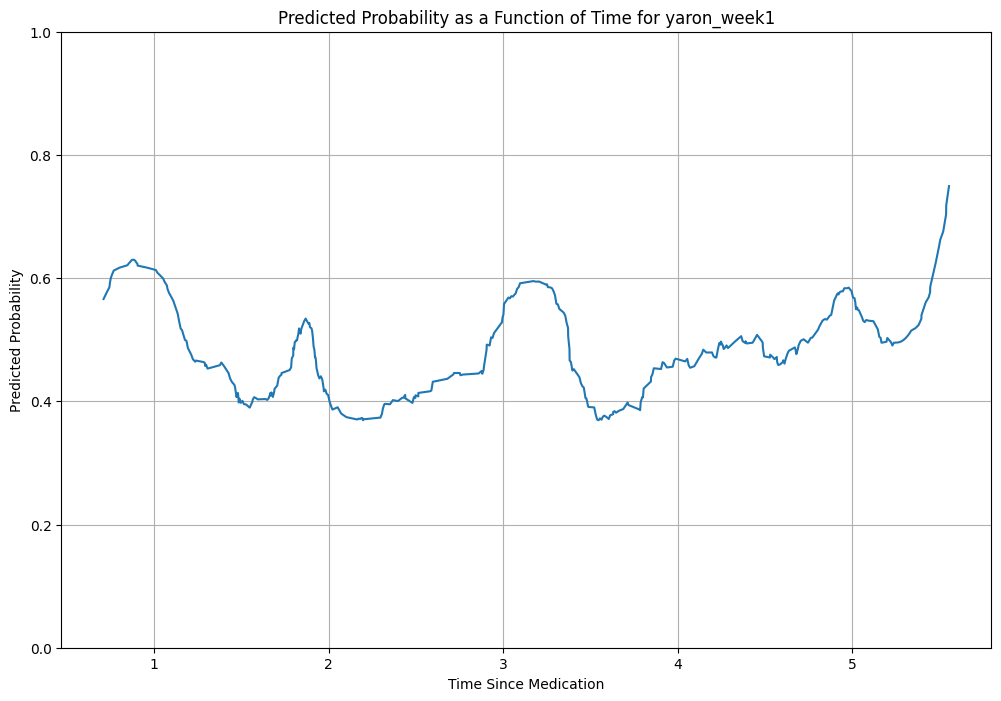

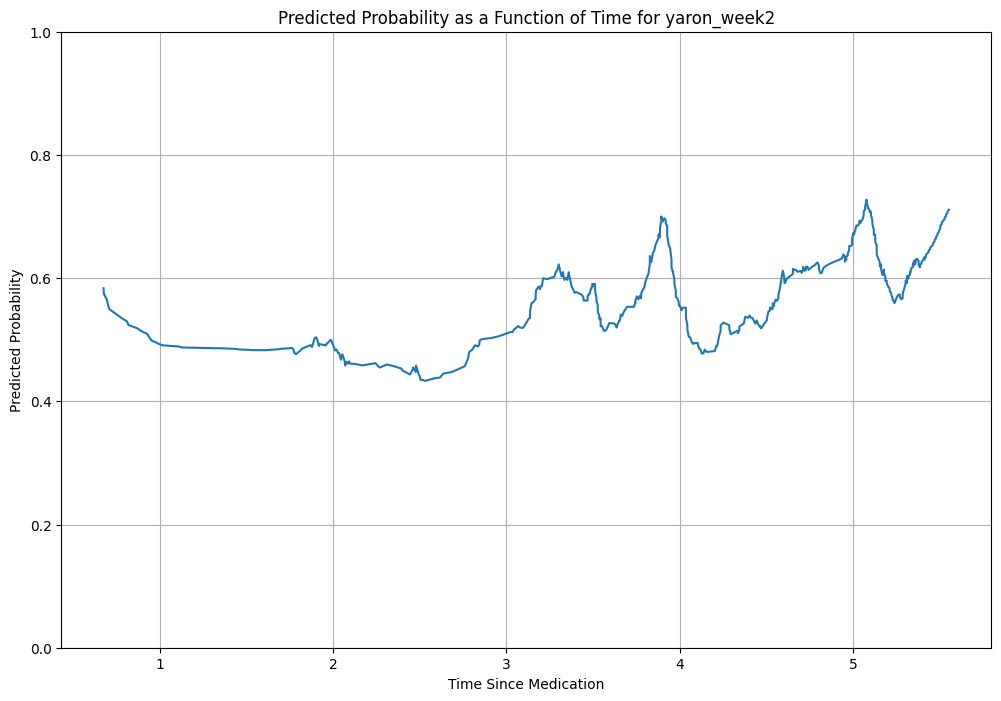

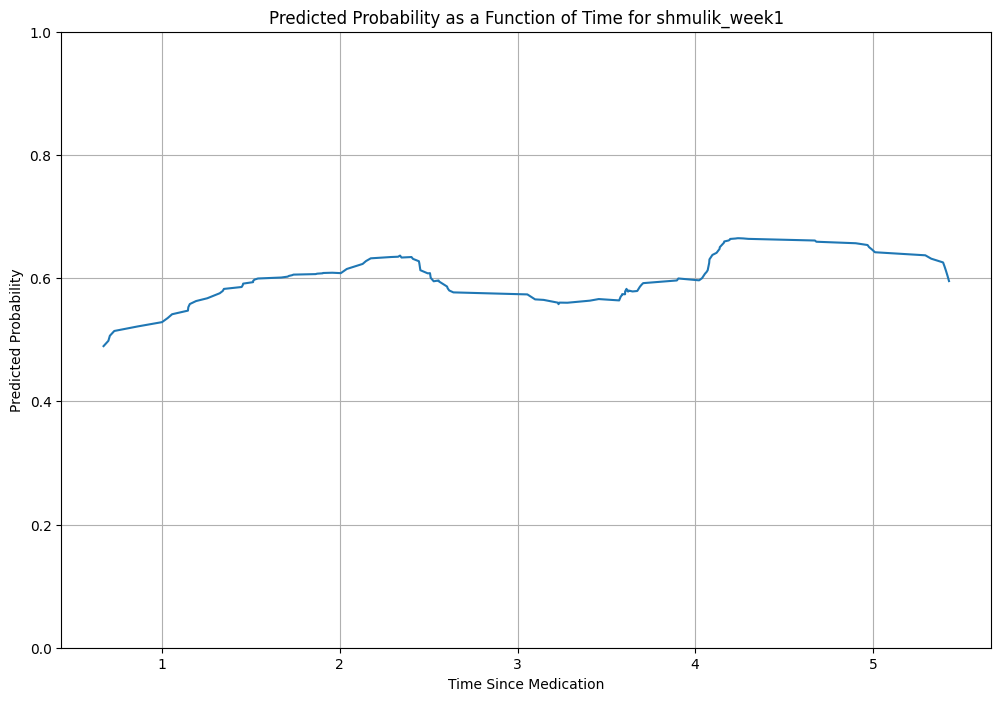

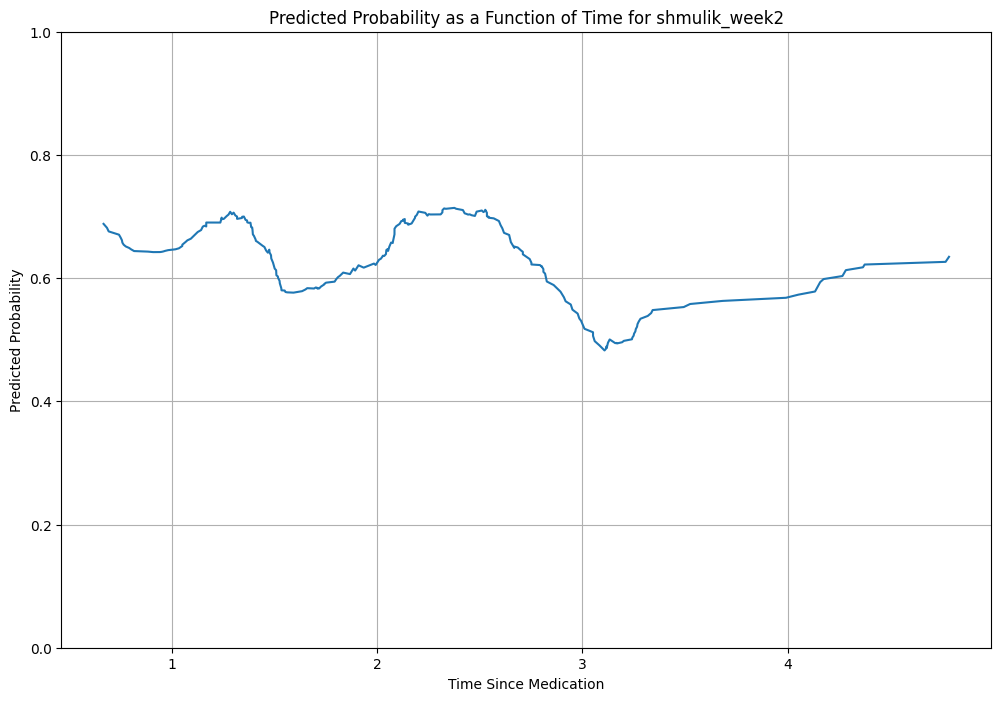

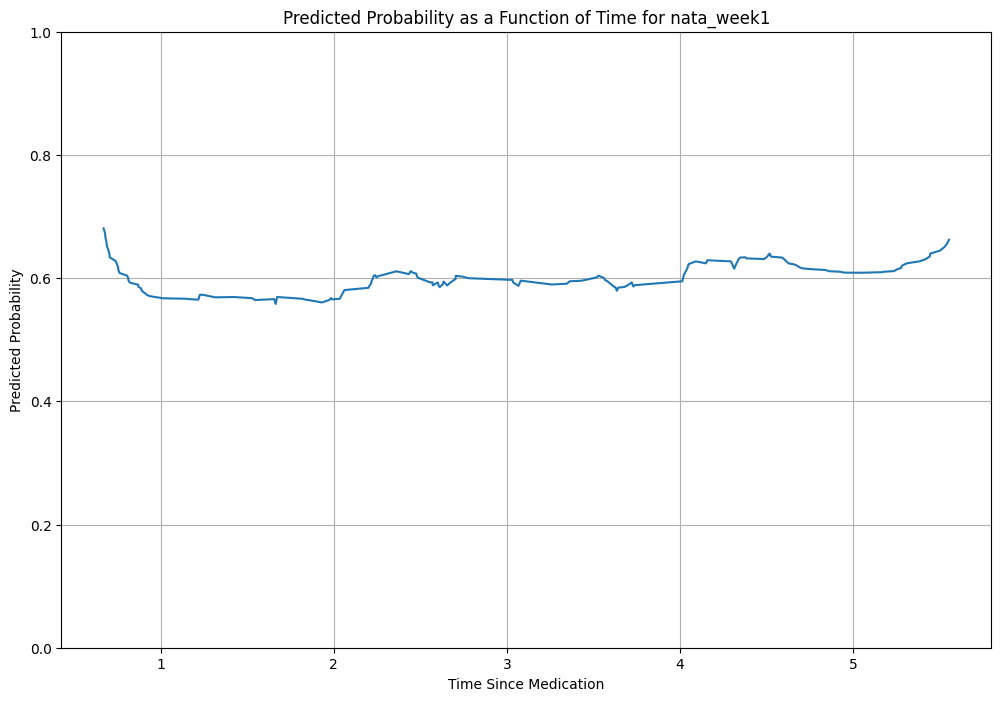

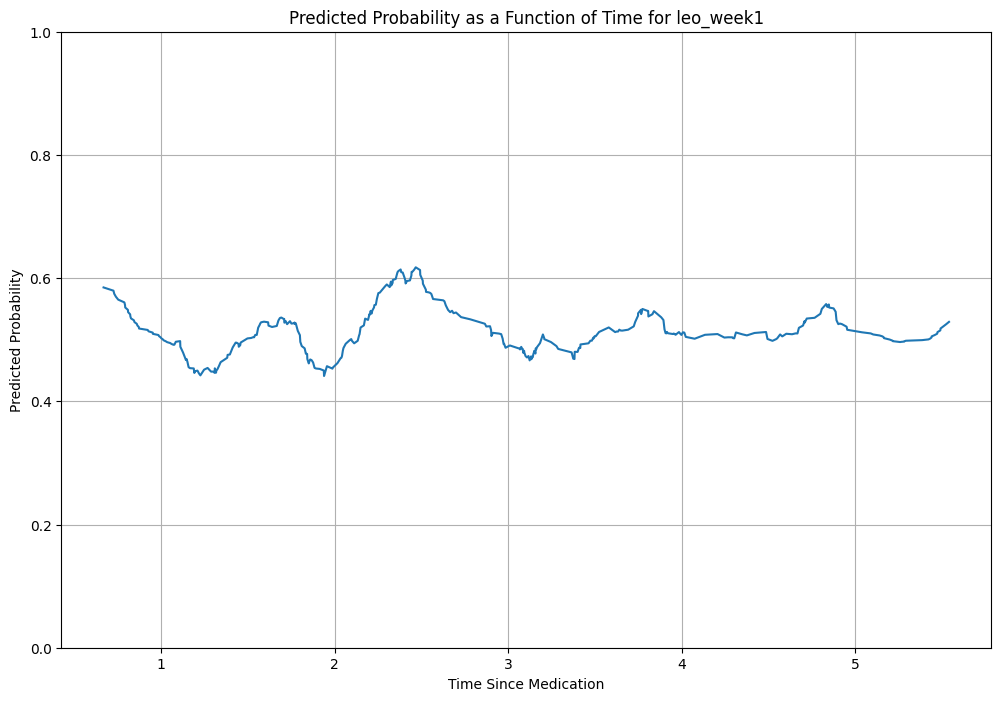

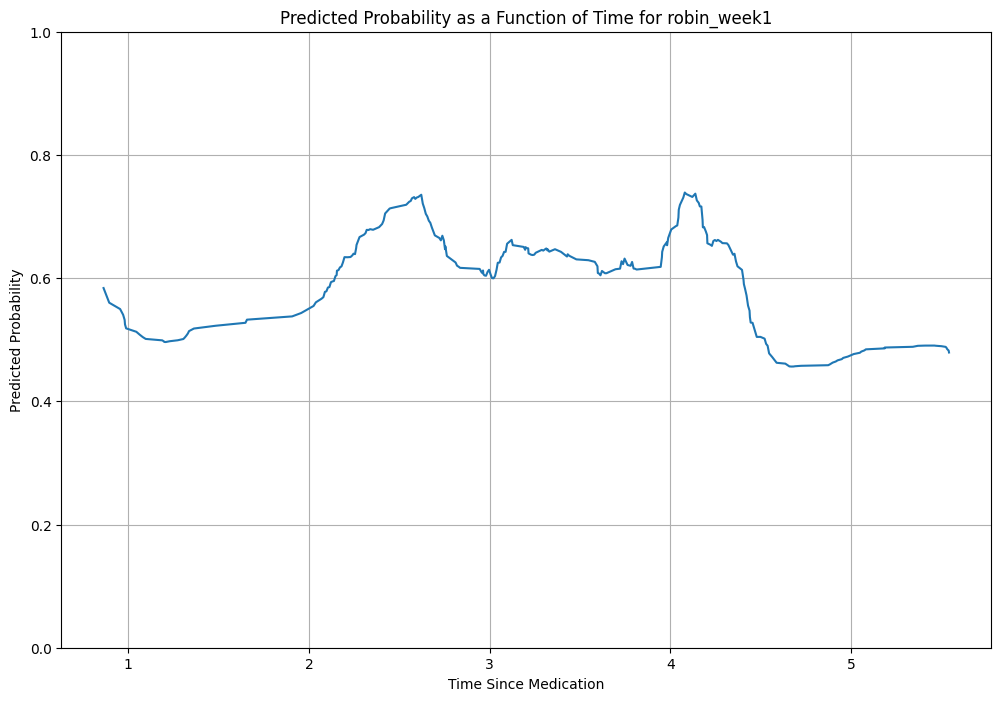

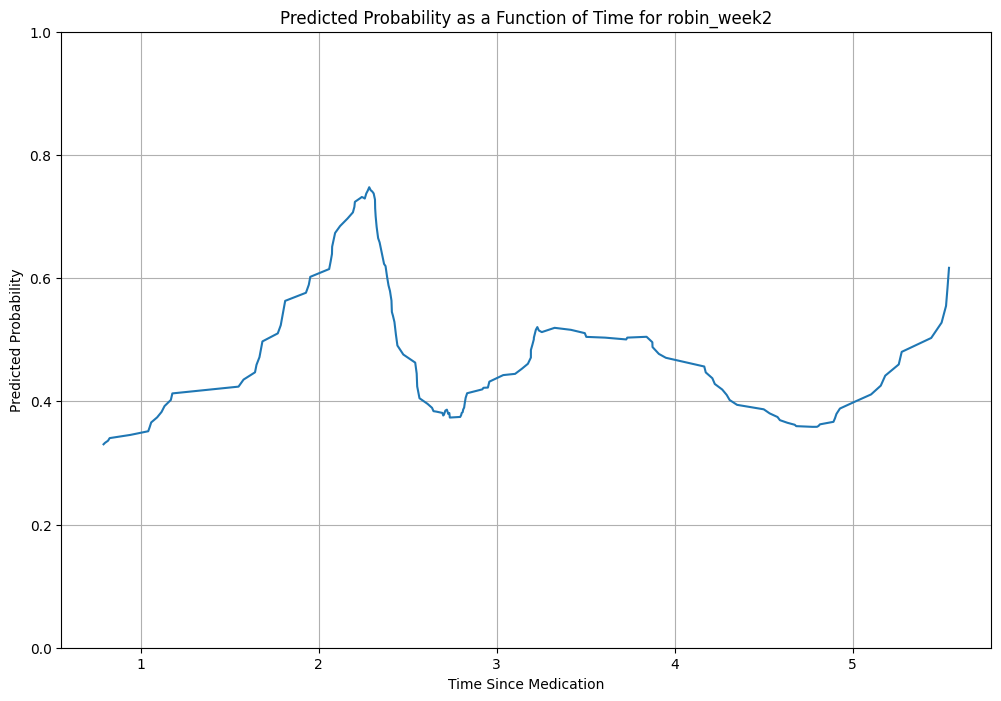

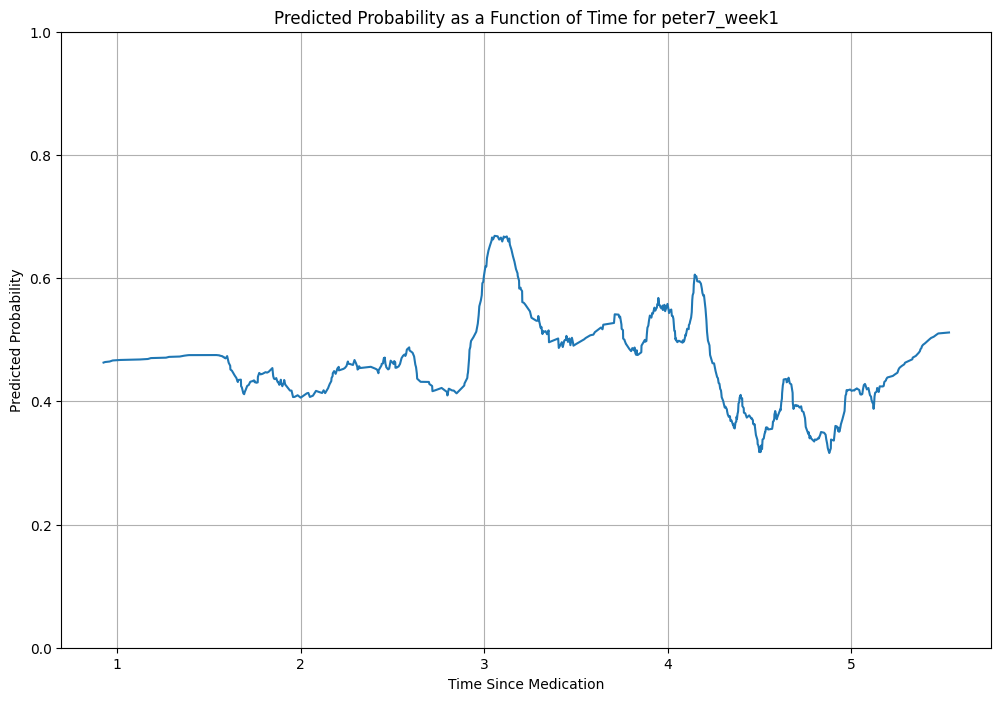

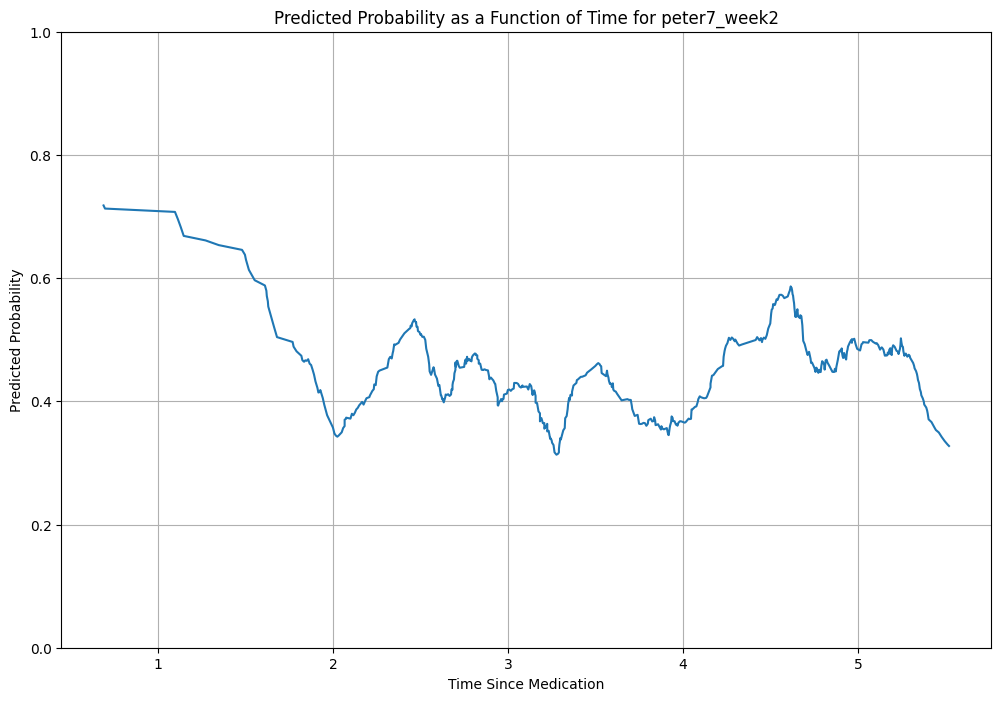

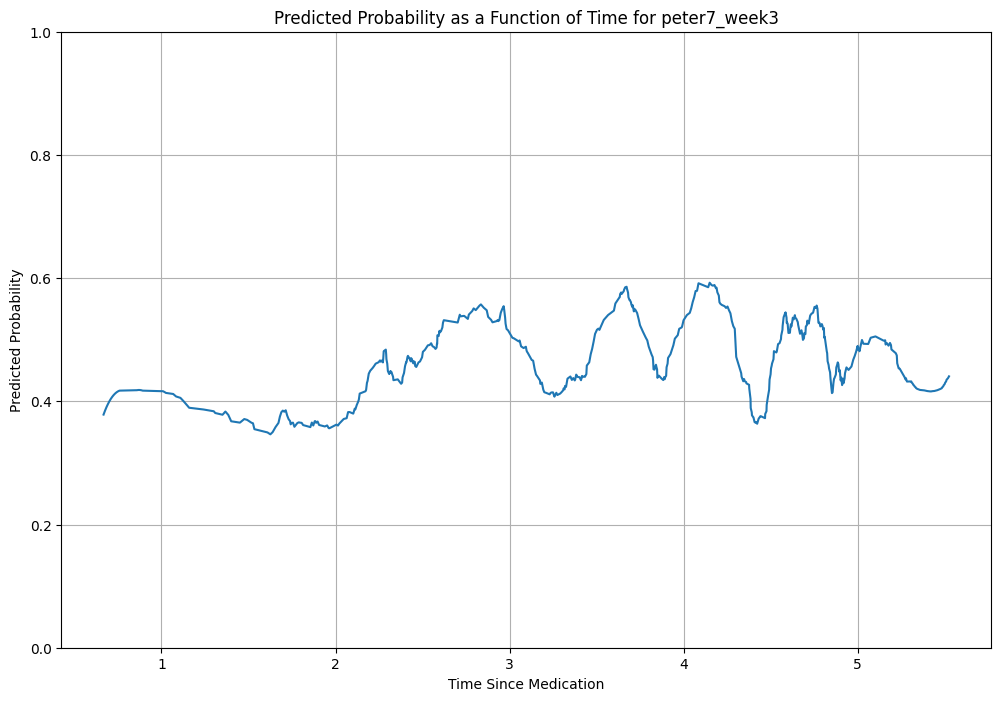

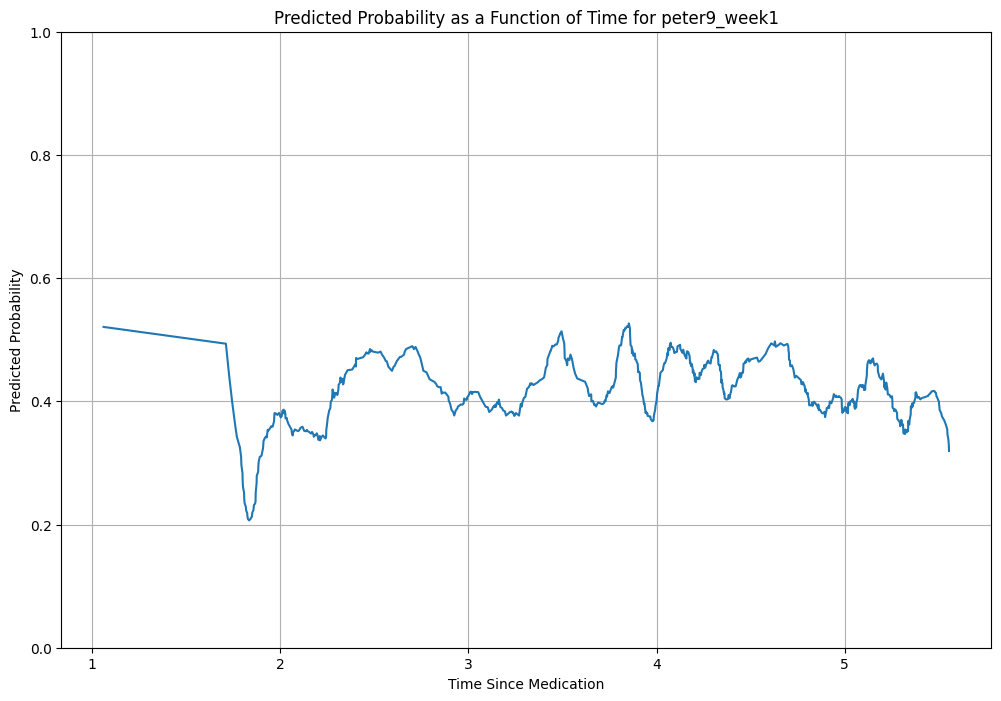

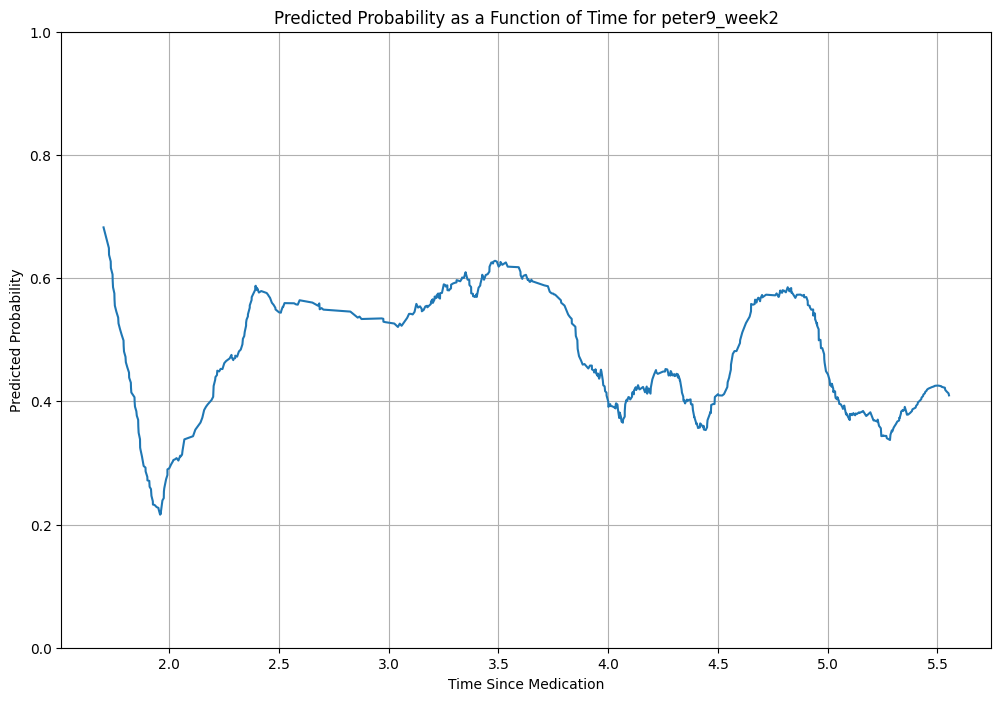

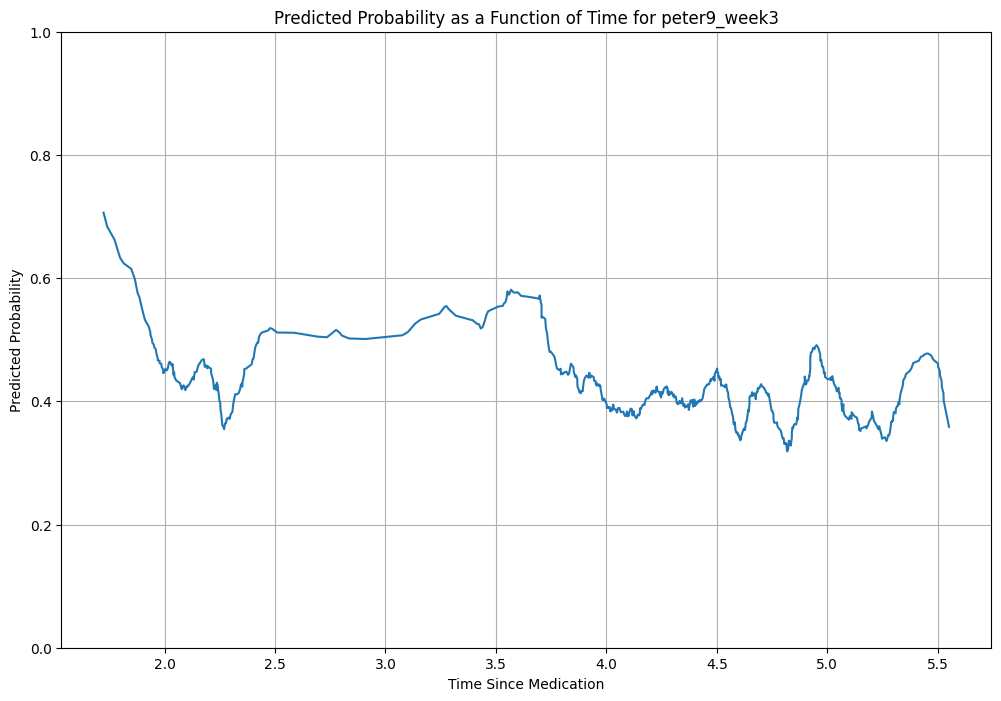

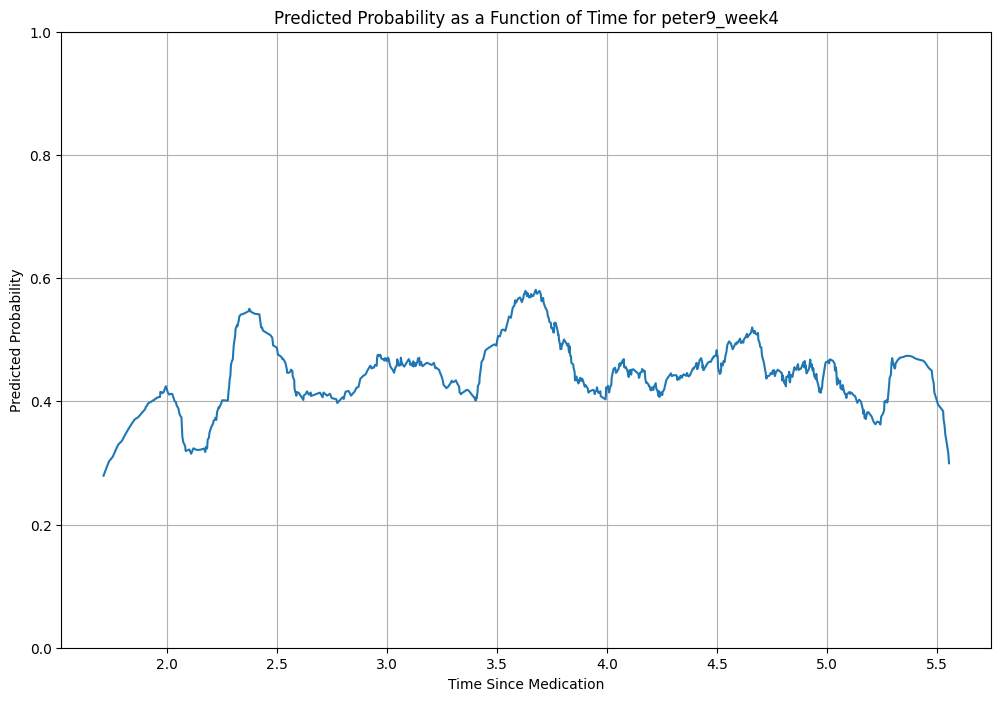

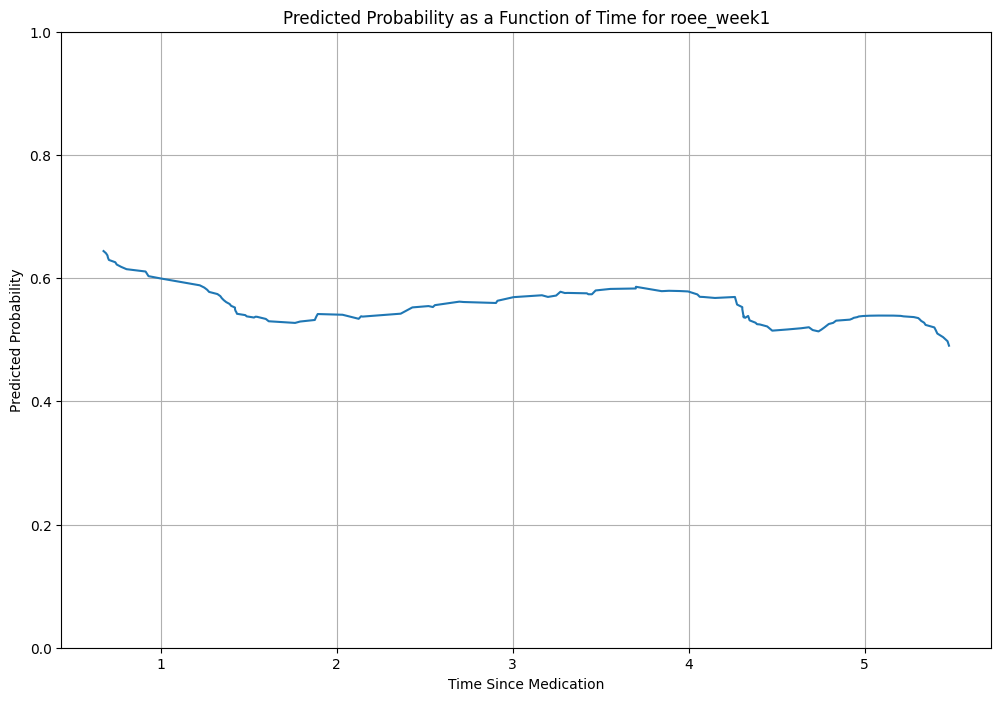

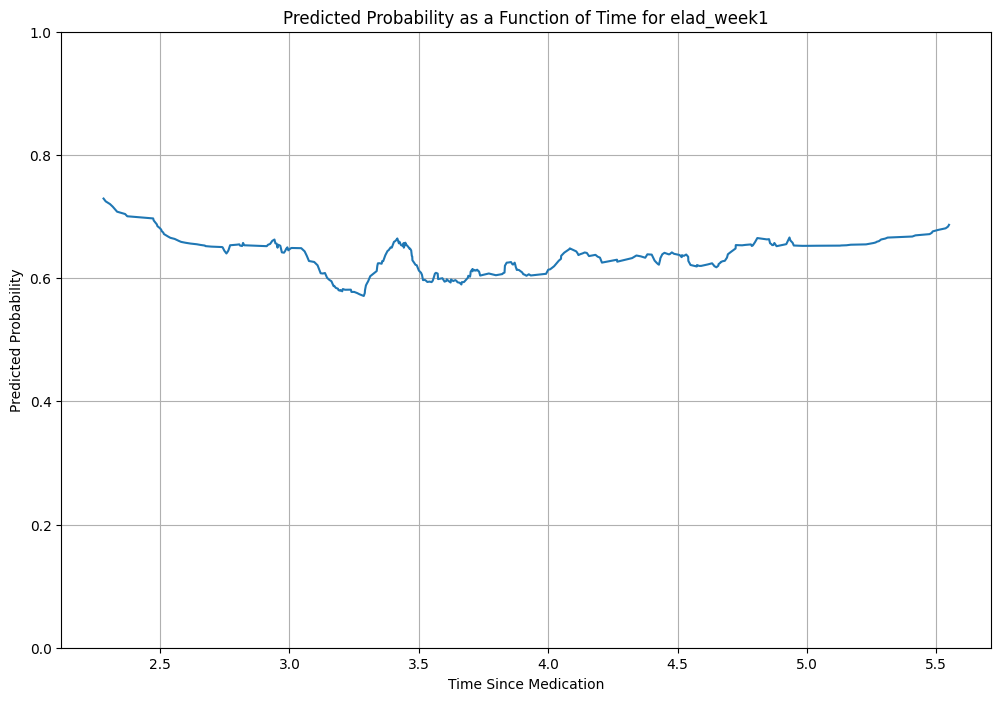

In [745]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

users = users_daily["user"].unique()

for user in users:
    df_filtered = users_daily[users_daily["user"] == user].sort_values(by='time_since_med')
    x = df_filtered['time_since_med']
    y = df_filtered['predicted_proba']
    plt.figure(figsize=(12, 8))
    y_savgol = savgol_filter(y, window_length=67, polyorder=3)
    plt.plot(x, y_savgol)
    plt.xlabel('Time Since Medication')
    plt.ylabel('Predicted Probability')
    plt.ylim(0, 1)
    plt.title(f'Predicted Probability as a Function of Time for {user}')
    plt.grid(True)
    plt.show()


# 3.GNN <a class="anchor" id="3"></a>


In [1527]:
trial_data = pd.read_csv('trial_data.csv')
trial_data['user'] = trial_data['user'] + '_' + trial_data['med'].astype(str)
unique_users = trial_data['user'].unique()
node1 =[]
node2 = []
y = []
for user in unique_users:
    windowed_data = trial_data[trial_data['user'] == user]
    first_index = windowed_data.index[0]
    last_index = windowed_data.index[-1]
    node1.append(first_index)
    node2.append(first_index+1)
    for i in range(first_index+1,last_index):
        node1.append(i)
        node2.append(i-1)
        node1.append(i)
        node2.append(i+1)
    node1.append(last_index)
    node2.append(last_index-1)
    print(user)
    print(f"start:{first_index}")
    print(f"end:{last_index}")
edge_list = torch.tensor([
                         node1, # Source Nodes
                         node2  # Target Nodes
                        ], dtype=torch.long)

MIM2028_0
start:0
end:66
MIM2028_1
start:67
end:100
MIM2028_2
start:101
end:143
MIM2029_0
start:144
end:206
MIM2029_1
start:207
end:269
MI2M030_0
start:270
end:353
MI2M030_1
start:354
end:487
MI2M030_2
start:488
end:511
MI2M031_0
start:512
end:624
MI2M031_1
start:625
end:808
MI2M032_0
start:809
end:917
MI2M032_1
start:918
end:1039
MI2M033_0
start:1040
end:1145
MI2M033_1
start:1146
end:1266


In [1528]:
trial_data.loc[trial_data['user'] == 'MIM2028_1', 'med'] = 0
trial_data.loc[trial_data['user'] == 'MIM2028_2', 'med'] = 1
trial_data.loc[trial_data['user'] == 'MI2M030_1', 'med'] = 0
trial_data.loc[trial_data['user'] == 'MI2M030_2', 'med'] = 1
y = trial_data["med"].values.tolist()

In [1529]:
# List of features you want to extract
features = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean', 
            'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 
            'g_rms', 'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv']

# Extract the values for the specified features
nodes = trial_data[features].values.tolist()
node_features = torch.tensor(nodes,dtype=torch.long)
node_y = torch.tensor(y,dtype=torch.long)



In [1530]:
data = Data(x=node_features, edge_index=edge_list, y=node_y)


" Print the graph info "
print("Number of nodes: ", data.num_nodes)
print("Number of edges: ",data.num_edges)
print("Number of features per node (Length of feature vector): ", data.num_node_features,"\n")
print("Number of weights per edge (edge-features): ", data.num_edge_features, "\n")

" Plot the graph "

G = to_networkx(data)
#nx.draw_networkx(G)


Number of nodes:  1267
Number of edges:  2506
Number of features per node (Length of feature vector):  22 

Number of weights per edge (edge-features):  0 



In [1531]:
train_mask = torch.zeros(1267, dtype=torch.bool)
train_mask[:512] = True
#train_mask[1040:] = True

test_mask = torch.zeros(1267, dtype=torch.bool)
test_mask[1040:] = True

val_mask = torch.zeros(1267, dtype=torch.bool)
val_mask[-10:] = True


In [1532]:
class OurNet(torch.nn.Module):
    def __init__(self):
        super(OurNet, self).__init__()
        hidden_channels = 22
        self.conv1 = GATConv(hidden_channels, hidden_channels, heads=2, concat=True)
        self.conv2 = GATConv(hidden_channels * 2, hidden_channels, heads=2, concat=True)
        self.conv3 = GATConv(hidden_channels * 2, 2, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=0.4)

    def forward(self, x, edge_index):
        x = x.float()
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        embeddings = x
        x = self.conv3(x, edge_index)
        return embeddings, F.log_softmax(x, dim=1)
        
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data.x, data.edge_index)[1][train_mask], data.y[train_mask]).backward()
    optimizer.step()

def test():
    model.eval()
    logits = model(data.x, data.edge_index)[1]
    accs = []
    for mask in [train_mask, val_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


In [1533]:
test_acc = 0
try_num = 0
while test_acc < 0.7:
    try_num += 1
    device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

    model, data = OurNet().to(device), data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    
    best_val_acc = test_acc = 0
    for epoch in range(1,5):
        train()
        _, val_acc, tmp_test_acc = test()
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        log = 'Epoch: {:03d}, Test: {:.4f}'
        
        if epoch % 1 == 0:
            print(log.format(epoch, test_acc))
print(f"try number: {try_num}")

Epoch: 001, Test: 0.5286
Epoch: 002, Test: 0.5286
Epoch: 003, Test: 0.5286
Epoch: 004, Test: 0.5286
Epoch: 001, Test: 0.6608
Epoch: 002, Test: 0.6608
Epoch: 003, Test: 0.6608
Epoch: 004, Test: 0.6608
Epoch: 001, Test: 0.5419
Epoch: 002, Test: 0.5419
Epoch: 003, Test: 0.5419
Epoch: 004, Test: 0.5419
Epoch: 001, Test: 0.0000
Epoch: 002, Test: 0.0000
Epoch: 003, Test: 0.0000
Epoch: 004, Test: 0.0000
Epoch: 001, Test: 0.5463
Epoch: 002, Test: 0.5463
Epoch: 003, Test: 0.5463
Epoch: 004, Test: 0.5463
Epoch: 001, Test: 0.0000
Epoch: 002, Test: 0.0000
Epoch: 003, Test: 0.0000
Epoch: 004, Test: 0.0000
Epoch: 001, Test: 0.0000
Epoch: 002, Test: 0.0000
Epoch: 003, Test: 0.0000
Epoch: 004, Test: 0.0000
Epoch: 001, Test: 0.5154
Epoch: 002, Test: 0.5154
Epoch: 003, Test: 0.5154
Epoch: 004, Test: 0.5154
Epoch: 001, Test: 0.0000
Epoch: 002, Test: 0.0000
Epoch: 003, Test: 0.0000
Epoch: 004, Test: 0.6035
Epoch: 001, Test: 0.0000
Epoch: 002, Test: 0.0000
Epoch: 003, Test: 0.5419
Epoch: 004, Test: 0.5419


In [1534]:
unique_users = users_daily['user'].unique()
node1 =[]
node2 = []
for user in unique_users:
    windowed_data_user = users_daily[users_daily['user'] == user]
    unique_dates = windowed_data_user["date"].unique()
    for date in unique_dates:
        windowed_data_user_date = windowed_data_user[windowed_data_user["date"] == date]
        first_index = windowed_data_user_date.index[0]
        last_index = windowed_data_user_date.index[-1]
        node1.append(first_index)
        node2.append(first_index+1)
        for i in range(first_index+1,last_index):
            node1.append(i)
            node2.append(i-1)
            node1.append(i)
            node2.append(i+1)
        node1.append(last_index)
        node2.append(last_index-1)
        print(user, date)
        print(last_index)

new_edge_list = torch.tensor([
                         node1, # Source Nodes
                         node2  # Target Nodes
                        ], dtype=torch.long)

# List of features you want to extract
features = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean', 
            'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 
            'g_rms', 'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv']

# Extract the values for the specified features
nodes = users_daily[features].values.tolist()
new_node_features = torch.tensor(nodes,dtype=torch.long)

new_data = Data(x=new_node_features, edge_index=new_edge_list)


yaron_week1 2.05
59
yaron_week1 3.05
160
yaron_week1 5.05
178
yaron_week1 11.05
413
yaron_week2 24.05
505
yaron_week2 26.05
691
yaron_week2 7.06
733
yaron_week2 8.06
900
shmulik_week1 16.01
936
shmulik_week1 17.01
959
shmulik_week1 18.01
983
shmulik_week1 19.01
999
shmulik_week1 22.01
1028
shmulik_week2 23.01
1057
shmulik_week2 24.01
1186
shmulik_week2 25.01
1197
shmulik_week2 29.01
1216
shmulik_week2 30.01
1283
nata_week1 1.11
1324
nata_week1 2.11
1358
nata_week1 4.11
1396
nata_week1 6.11
1428
nata_week1 8.11
1451
leo_week1 24.01
1514
leo_week1 26.01
1554
leo_week1 2.02
1693
leo_week1 9.02
1719
leo_week1 10.02
1780
leo_week1 11.02
1830
robin_week1 13.01
1874
robin_week1 15.01
1894
robin_week1 16.01
1903
robin_week1 18.01
1919
robin_week1 23.01
2091
robin_week2 30.01
2101
robin_week2 24.03
2167
robin_week2 26.03
2203
robin_week2 27.03
2222
robin_week2 29.03
2251
peter7_week1 2.09
2419
peter7_week1 3.09
2610
peter7_week1 4.09
2696
peter7_week1 5.09
2886
peter7_week2 6.09
3104
peter7_wee

In [1535]:
# get the new embedding for daily data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    embeddings, _ = model(new_data.x, new_data.edge_index)
tensor_np = embeddings.cpu().detach().numpy()  # Convert tensor to NumPy array if it's still on GPU
users_daily = pd.read_csv('users_daily.csv')
# Define the new feature names for the tensor columns
new_features = [f'x{i+1}' for i in range(tensor_np.shape[1])]

# Ensure the dataframe and tensor have the same number of rows
if users_daily.shape[0] != tensor_np.shape[0]:
    print(f"Error: DataFrame has {users_daily.shape[0]} rows, but the tensor has {tensor_np.shape[0]} rows.")
else:
    # Add the tensor data as new columns to the dataframe
    users_daily[new_features] = tensor_np
    print("New features added successfully!")


New features added successfully!


In [1536]:
# get the new embedding for trial data

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    embeddings, _ = model(data.x, data.edge_index)
tensor_np = embeddings.cpu().detach().numpy()  # Convert tensor to NumPy array if it's still on GPU

# Define the new feature names for the tensor columns
new_features = [f'x{i+1}' for i in range(tensor_np.shape[1])]

# Ensure the dataframe and tensor have the same number of rows
if trial_data.shape[0] != tensor_np.shape[0]:
    print(f"Error: DataFrame has {trial_data.shape[0]} rows, but the tensor has {trial_data.shape[0]} rows.")
else:
    # Add the tensor data as new columns to the dataframe
    trial_data[new_features] = tensor_np
    print("New features added successfully!")


trial_data['time_bin_start'] = trial_data['time_bin_start'] /3600   
trial_data = trial_data.rename(columns={'time_bin_start': 'day_time'})
users_with_3_unique_med = trial_data.groupby('user')['med'].nunique()
users_with_3_unique_med = users_with_3_unique_med[users_with_3_unique_med == 3].index
trial_data.loc[trial_data['user'].isin(users_with_3_unique_med), 'med'] = trial_data.loc[trial_data['user'].isin(users_with_3_unique_med), 'med'].replace({1: 0, 2: 1})
trial_data['user'] = trial_data['user'].str[:-2]


New features added successfully!


# 4. Post-GNN Evaluation of Trial Data <a class="anchor" id="4"></a>


### 4.1 LDA <a class="anchor" id="4.1"></a>


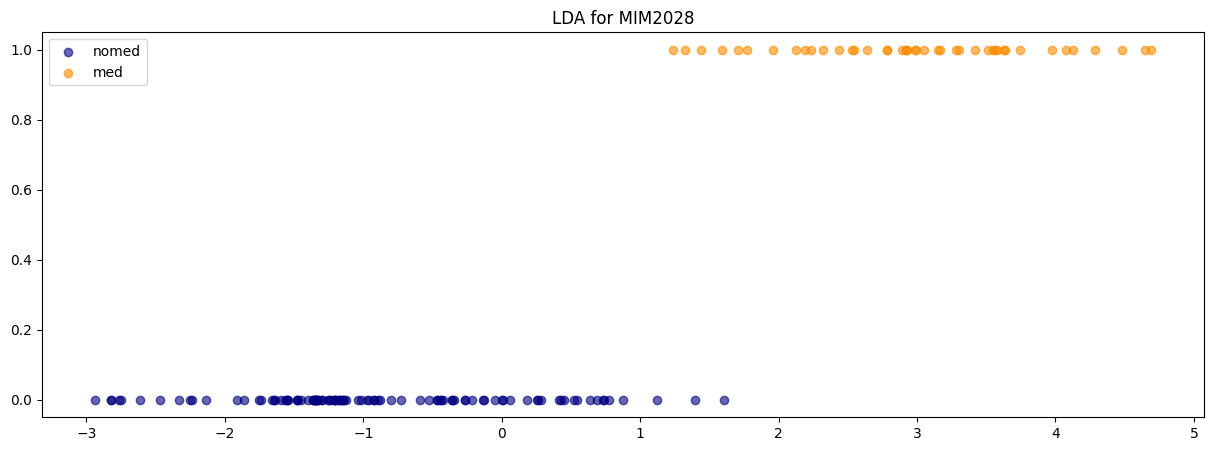

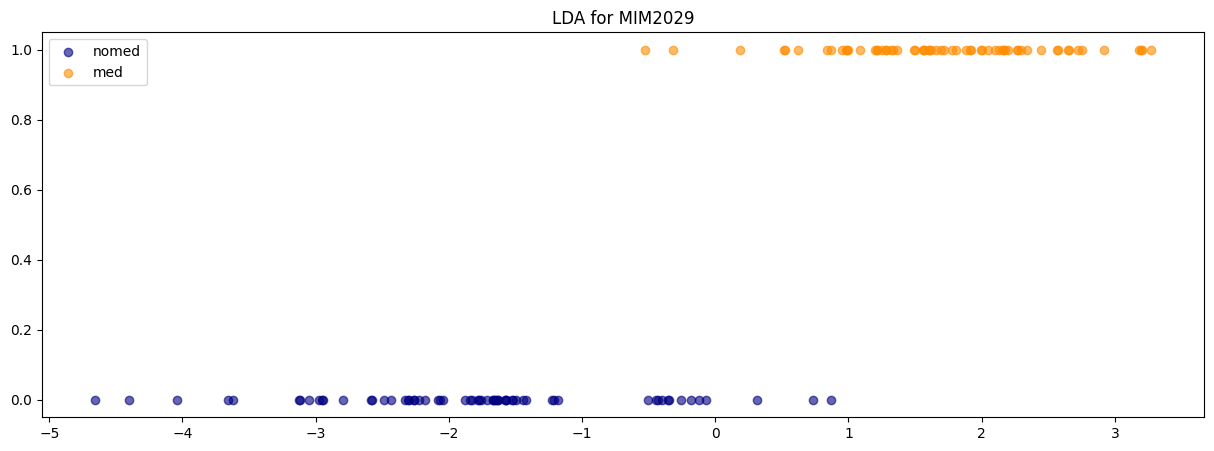

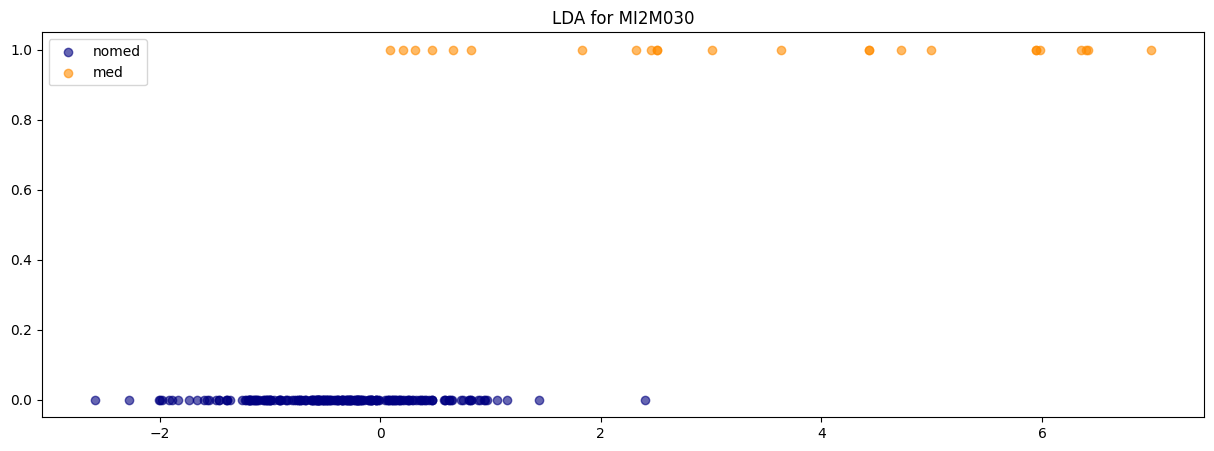

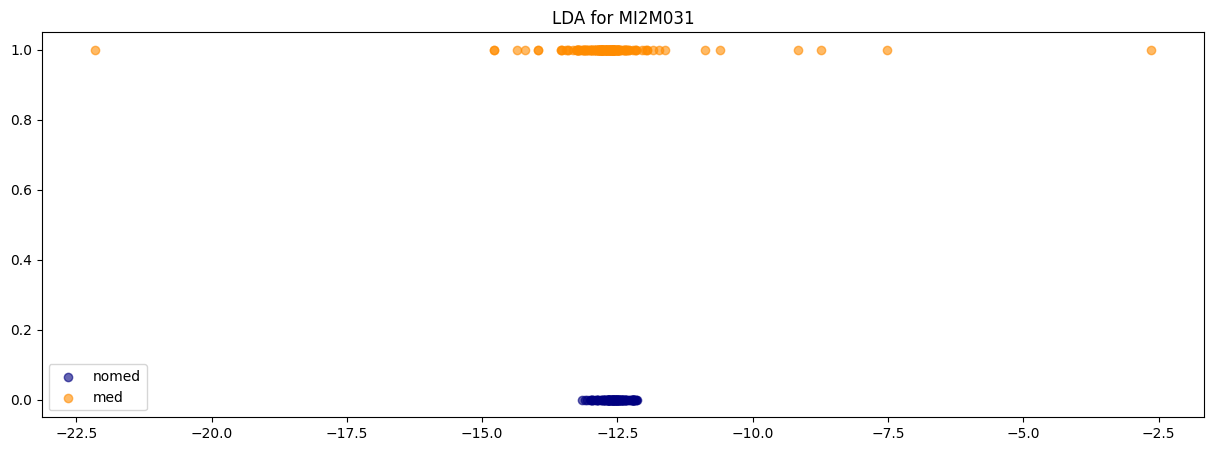

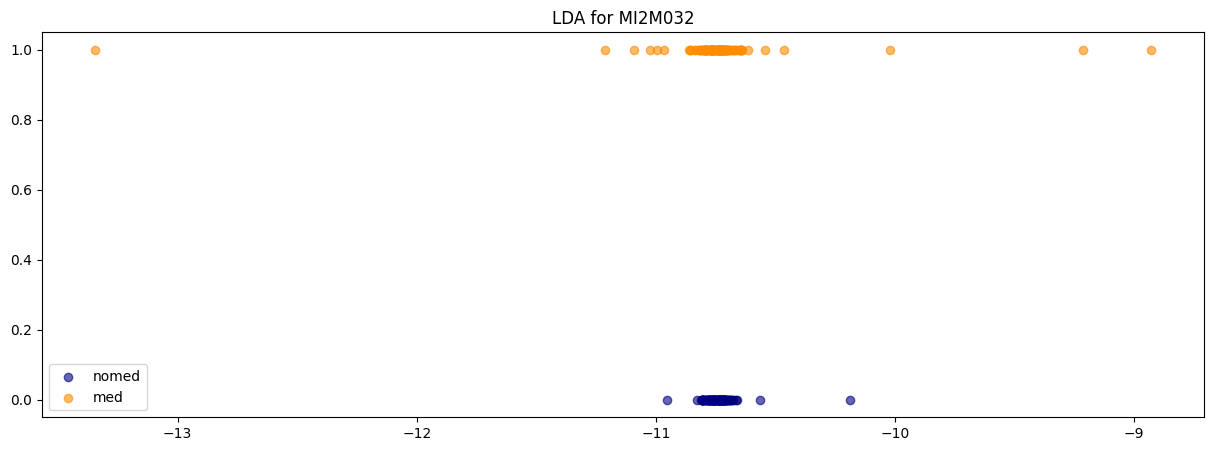

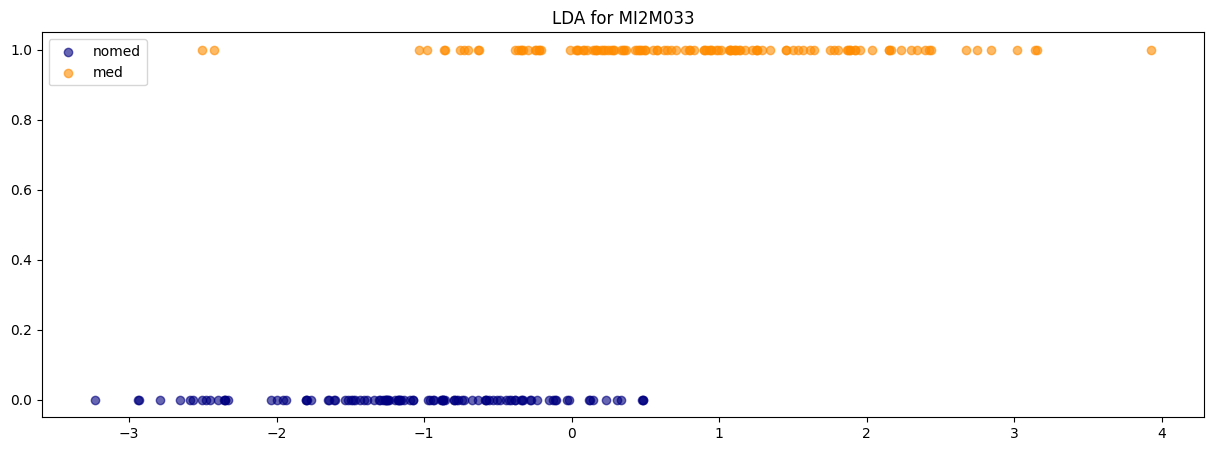

In [1537]:
unique_users = trial_data['user'].unique()
for user in unique_users:
    med_status = {"nomed": 0,"med": 1}
    windowed_data = trial_data[trial_data['user'] == user]
    windowed_data = windowed_data.drop(columns=['day_time', 'user','x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean', 
            'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 
            'g_rms', 'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv']  )
    windowed_data.rename(columns={'med':'target'}, inplace=True)
    X_train = windowed_data.drop(['target'],axis=1).reset_index()
    Y_train = windowed_data['target'].reset_index()
    optional_med_status = np.array([0,1])
    if optional_med_status.shape[0] == 2:
        lda_dim = 1
    elif optional_med_status.shape[0] < 2:
        print('fail: not enough status for med analysis')
    else:
        lda_dim = 2
    X_train = X_train.drop(['index'],axis=1)
    X_r = X_train.values
    y   = Y_train['target'].values
    target_names = np.array(["nomed", "med"])
    
    
    if lda_dim == 2:
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        df = pd.DataFrame({'lda_value1':X_r2[:,0],'lda_value2':X_r2[:,1],'Label':y})
    
        colors = ["navy", "darkorange","cyan"]
        plt.figure()
        for color, i, target_name in zip(colors, list(optional_med_status), target_names):
            plt.scatter(
                X_r2[y == i,0], X_r2[y == i,1], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA all states")
        plt.savefig(save_path + 'lda.png')
        plt.show()
        
        sil_score = []
        p_value   = []
        x1 = X_train.values[y==0]
        for stat in optional_med_status:
            if stat ==0:
                continue
            x2 = X_train.values[y==stat]
            x3 = np.concatenate((x1,x2),axis=0)
            sil_score.append(metrics.silhouette_score(x3,lda.predict(x3),metric='euclidean'))
            p_value.append(stats.ttest_ind(a=X_r2[y==0,0],b=X_r2[y==i,0],equal_var=False))
            
        X_r = X_train.values
        y   = Y_train['target'].values
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        without_center = [X_r2[y == 0,0].mean(), X_r2[y == 0,1].mean()]
        colors = ["darkorange",'cyan']
        plt.figure()
        for color, i, target_name in zip(colors, [1,2], target_names[1:]):
            plt.scatter(
                X_r2[y == i,0] - without_center[0], X_r2[y == i,1] - without_center[1], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA Aligned")
        plt.show()
        
        with1 = X_r2[y == 1][:,0].mean()
        with2 = X_r2[y == 2][:,0].mean()
        without = X_r2[y == 0][:,0].mean()
        colors = ['navy',"darkorange",'cyan']
        for color, i, target_name in zip(colors, [0,1,2], target_names):
            plt.scatter(
                X_r2[y == i][:,0].mean(), X_r2[y == i][:,0].mean(), alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("LDA Aggregate")
        plt.show()
    
    plt.rcParams['figure.figsize'] = [15, 5]
    
    if lda_dim == 1:
        lda = LinearDiscriminantAnalysis(n_components=1)
        X_r2 = lda.fit(X_r, y).transform(X_r)
        df = pd.DataFrame({'lda_value':X_r2[:,0],'Label':y})
        colors = ["navy", "darkorange"]
        plt.figure()
        for color, i, target_name in zip(colors, list(optional_med_status), target_names):
            plt.scatter(
                X_r2[y == i], y[y==i], alpha=0.6, color=color, label=target_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title(f"LDA for {user}")
        #plt.savefig(save_path + 'lda.png')
        plt.show()


### 4.2. ROC CURVE <a class="anchor" id="4.2"></a>


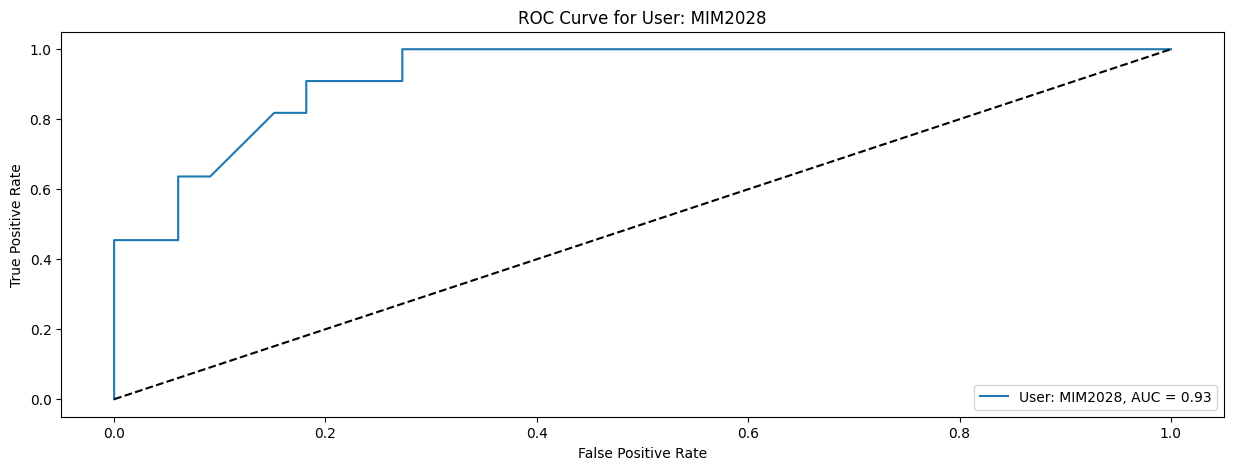

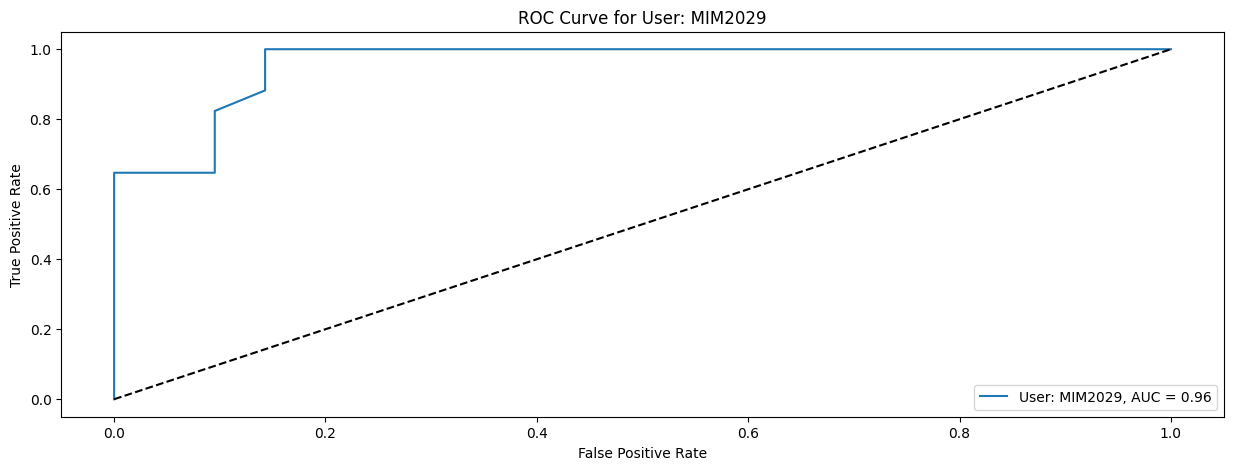

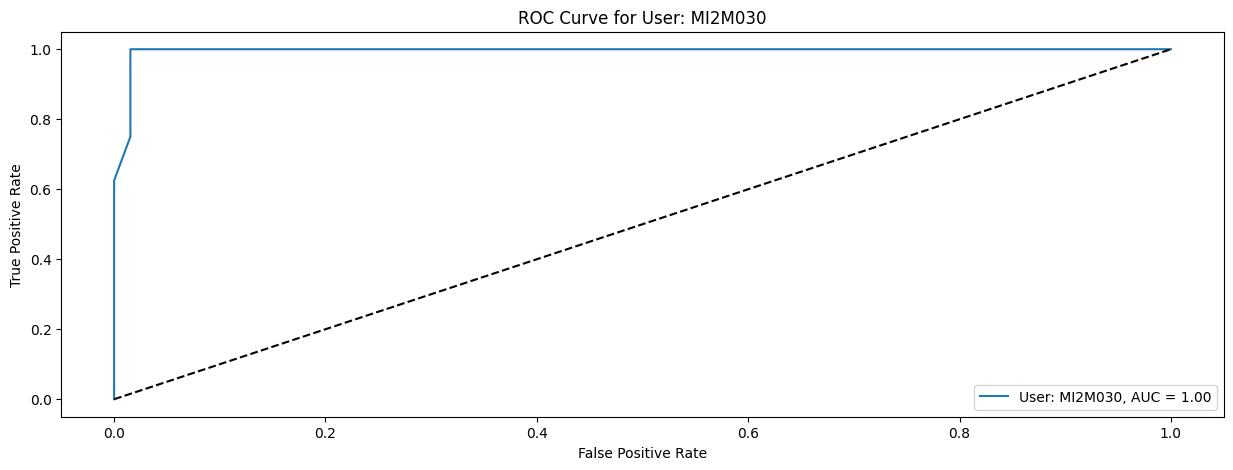

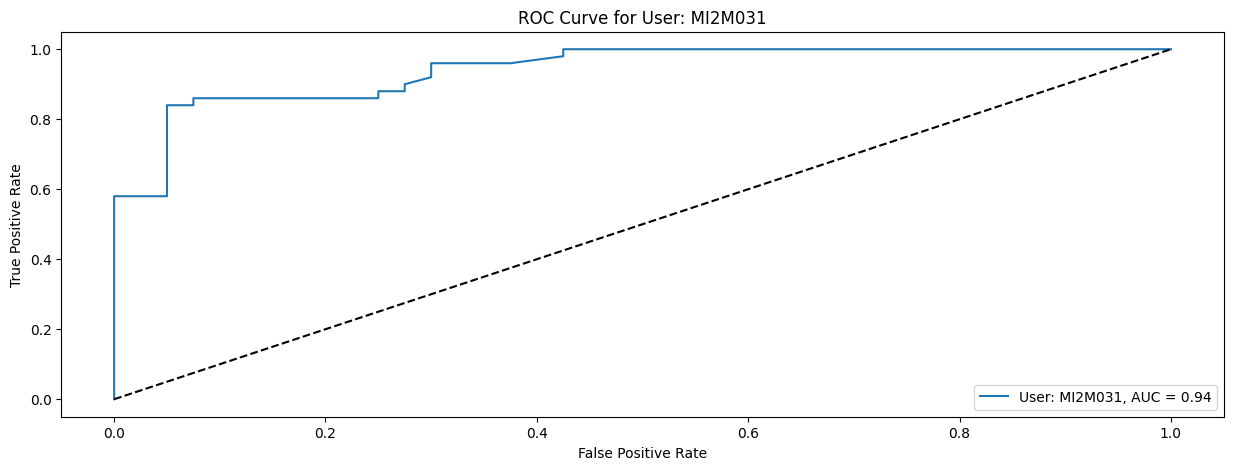

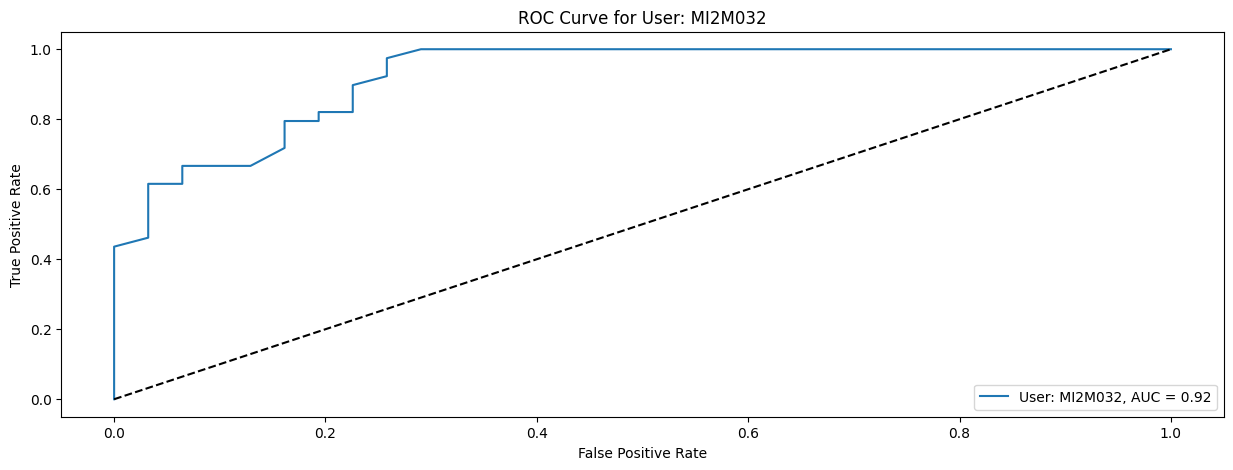

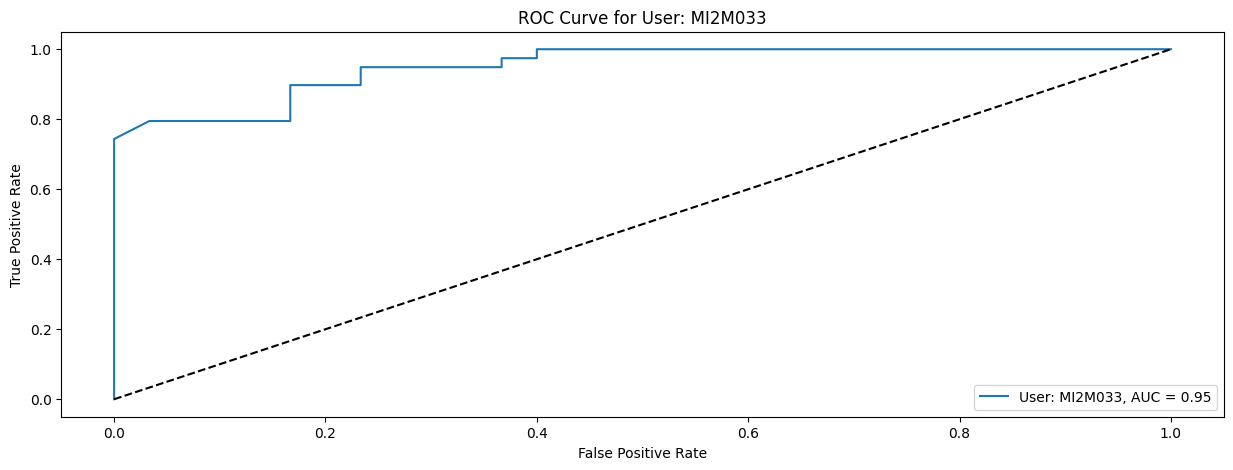

In [1538]:
unique_users = trial_data['user'].unique()

for user in unique_users:
    user_data = trial_data[trial_data['user'] == user].copy()
    user_data = user_data.drop(columns=['day_time', 'user','x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean', 
            'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 
            'g_rms', 'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv']  )

# Convert 'med' to binary if necessary - in our trial, a high dose (med=2) indicates that the physician deemed the regular dose (med=1) insufficiently effective.
    if user_data['med'].nunique() == 3:
        user_data['med'] = user_data['med'].replace({1: 0, 2: 1})

    # Split the data into features and target
    X = user_data.drop('med', axis=1)
    y = user_data['med']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a simple Random Forest model
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the AUC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'User: {user}, AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for User: {user}')
    plt.legend(loc='lower right')
    plt.show()


# 5. Post-GNN Consolidated Weekly Graphs of Observational Data <a class="anchor" id="5"></a>


In [1539]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

target_column = 'med'  
exclude_columns = ['time_since_med', 'user']  


X_train = trial_data.drop(columns=['day_time', 'user', 'med','x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean', 
            'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 
            'g_rms', 'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv']  )
y_train = trial_data[target_column]

X_test = users_daily.drop(columns=['user','date',"time_since_med", "day",'x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean', 
            'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 
            'g_rms', 'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv'])
#y_test = df2[target_column]

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Train the model on df1
rf.fit(X_train, y_train)

# Predict probabilities on df2
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # get probability of class 1
users_daily['predicted_proba'] = y_pred_proba



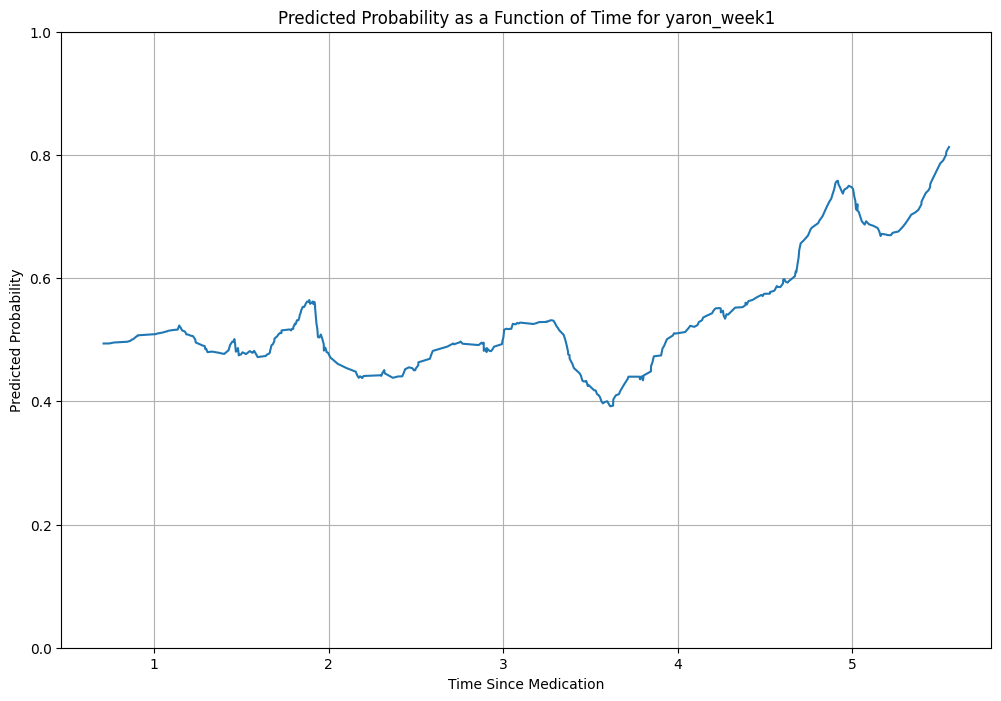

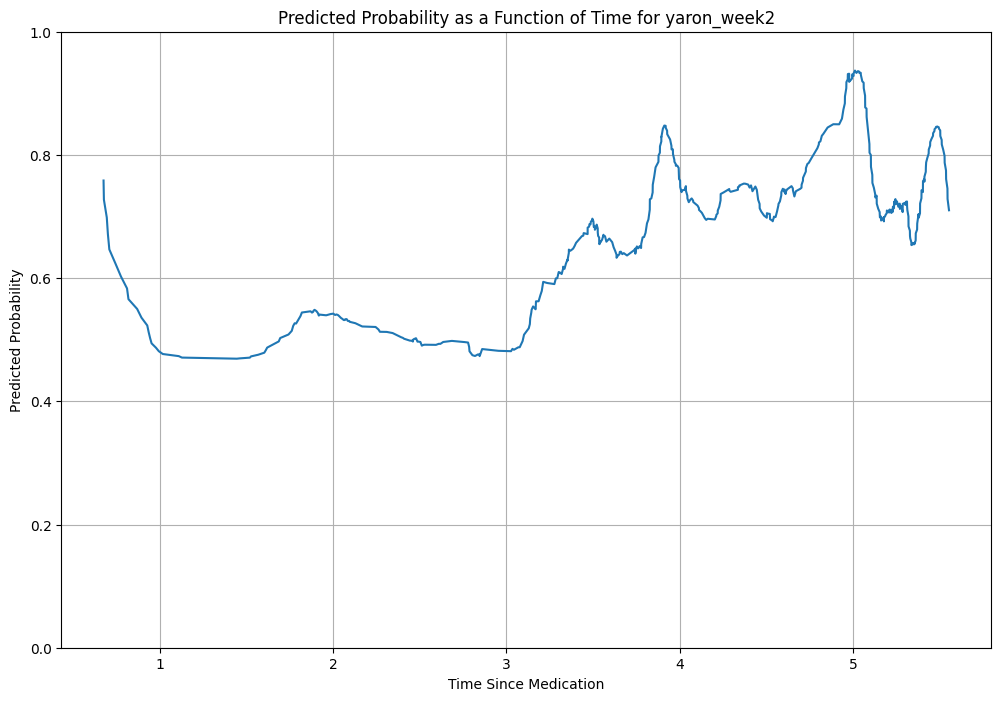

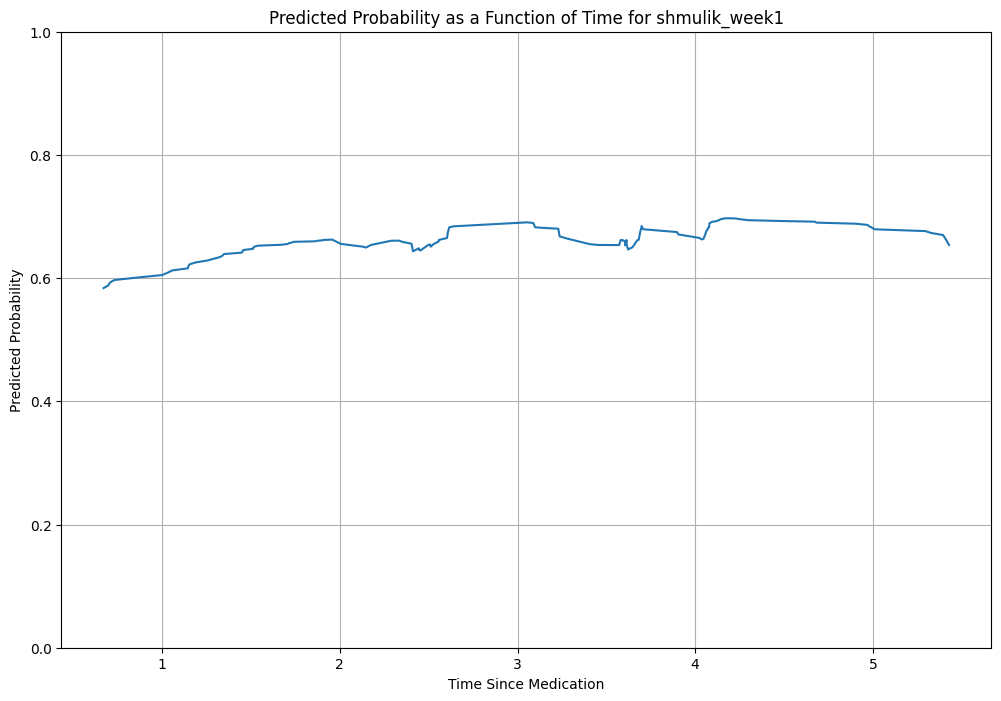

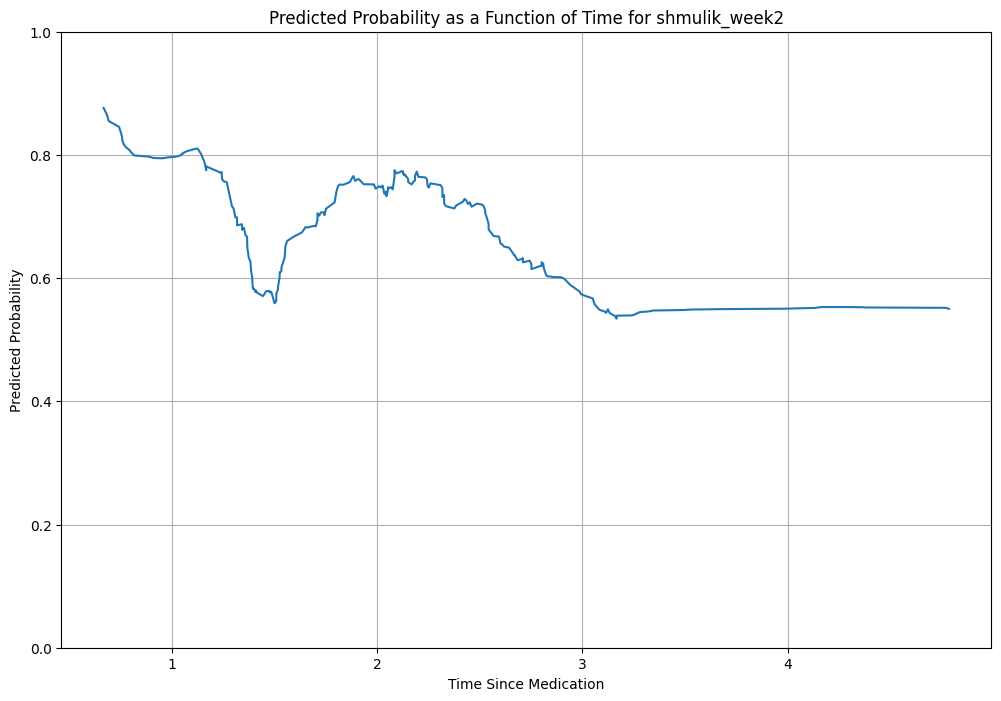

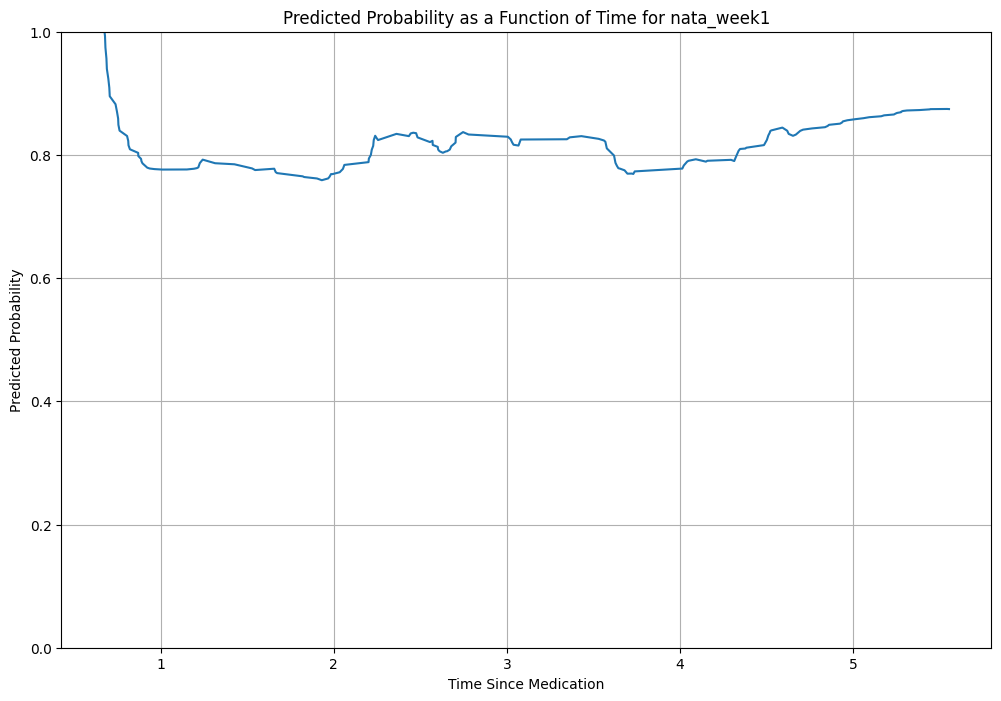

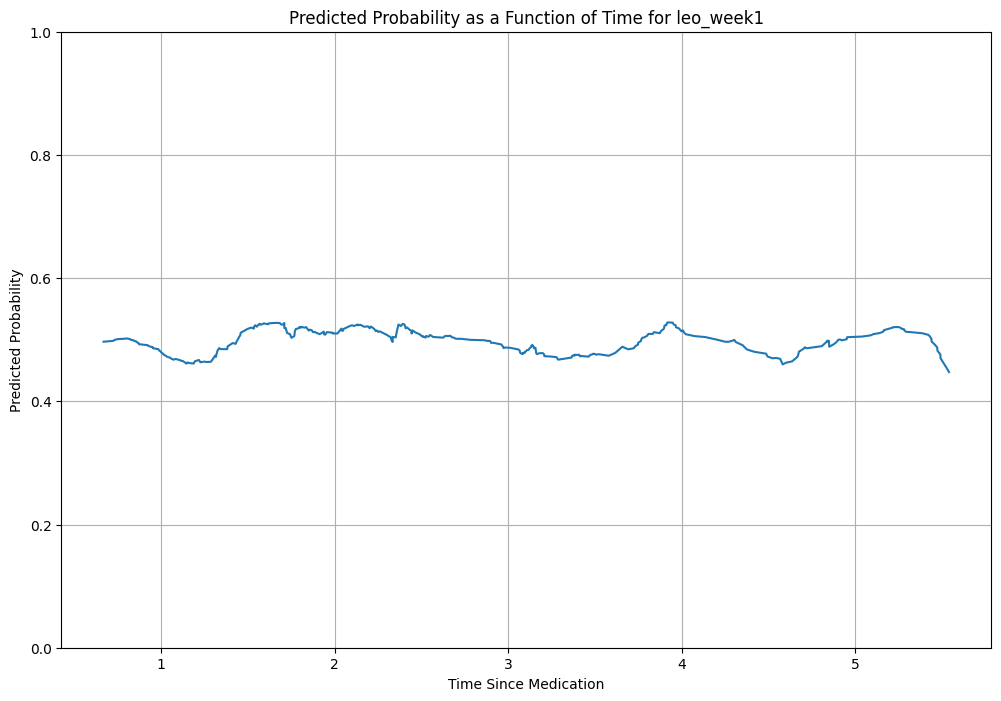

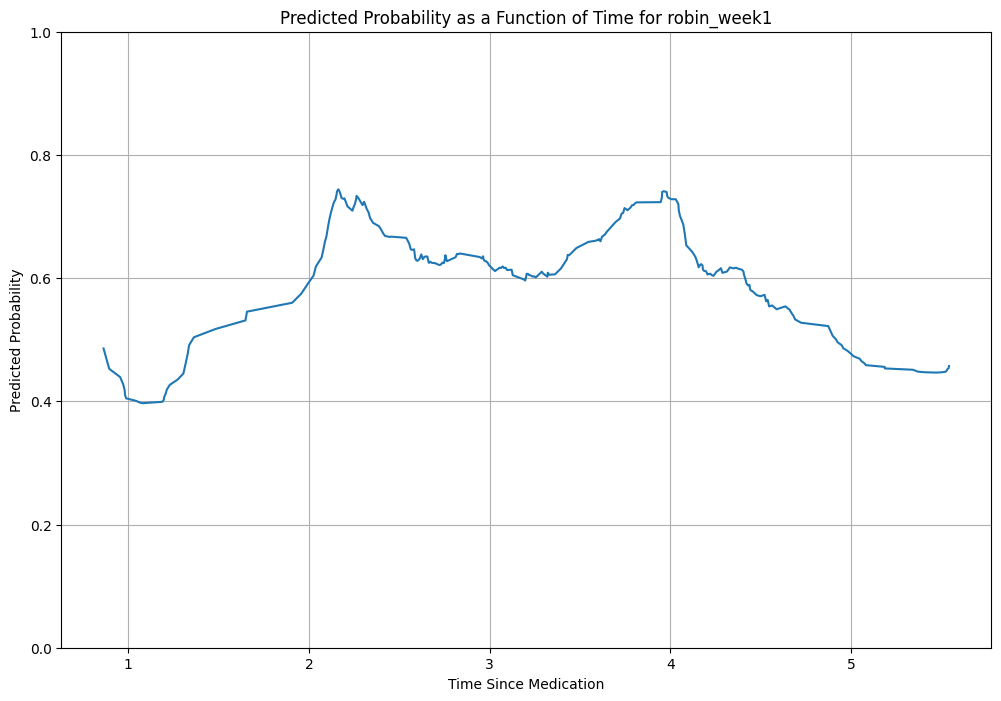

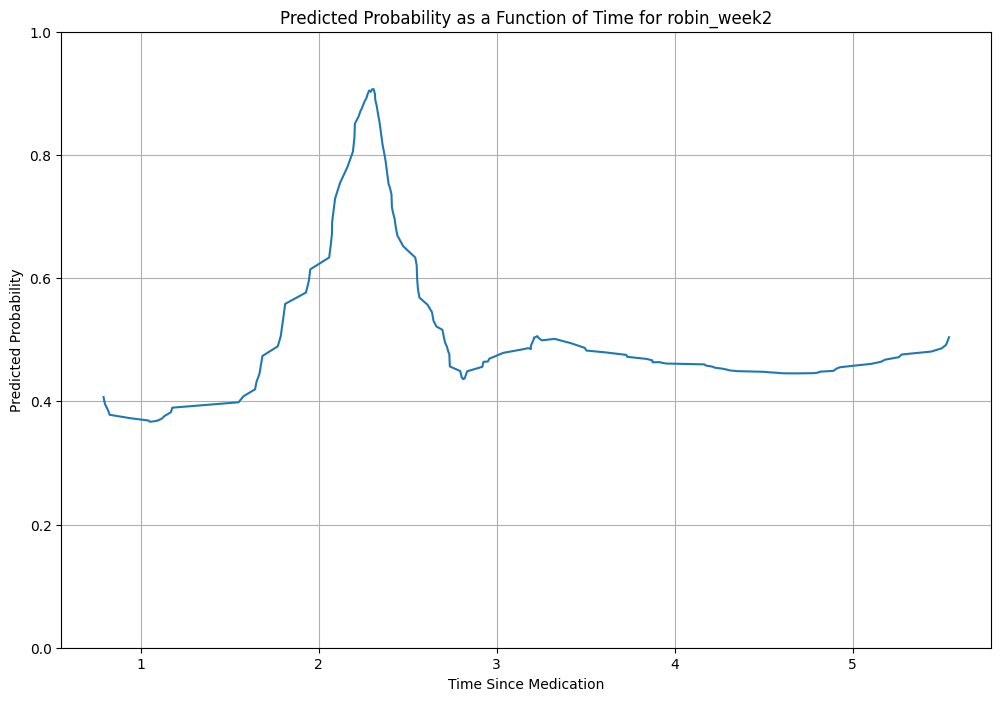

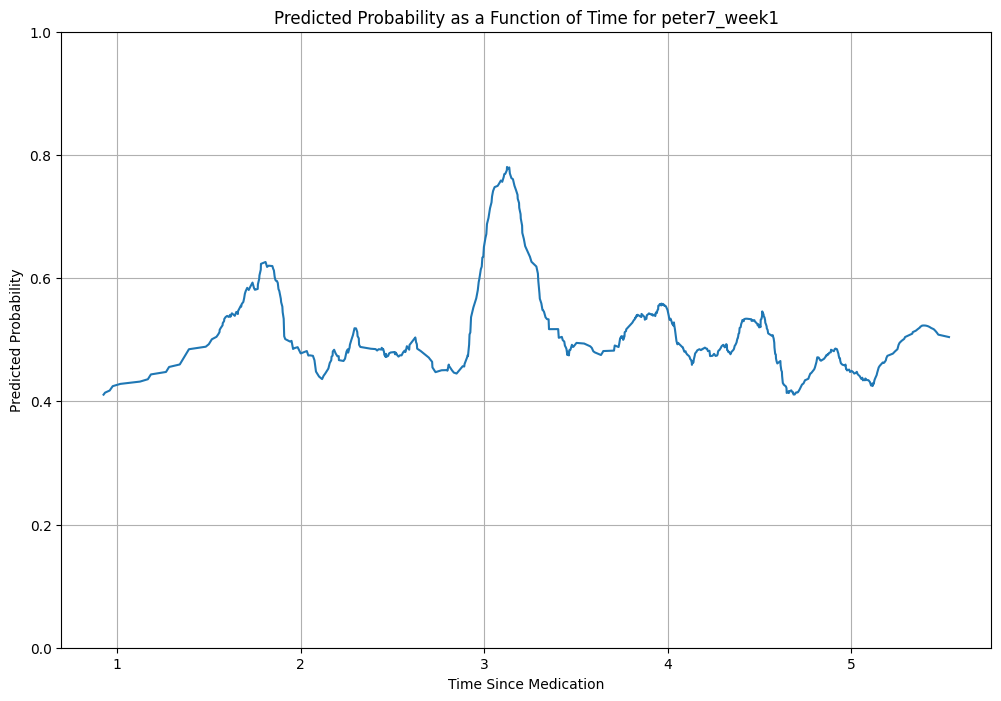

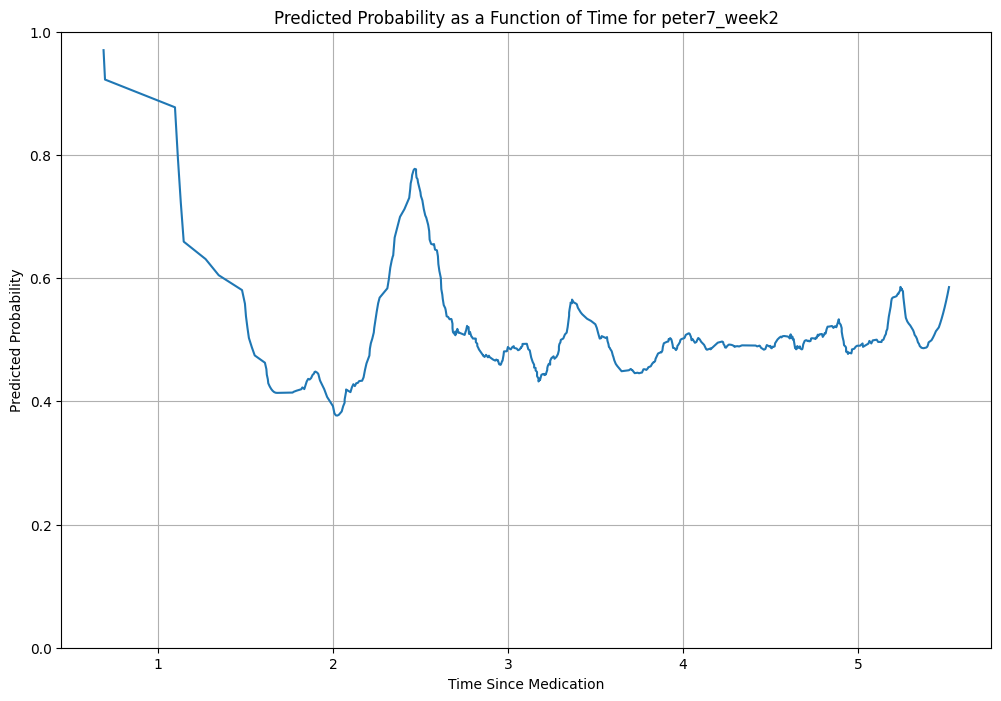

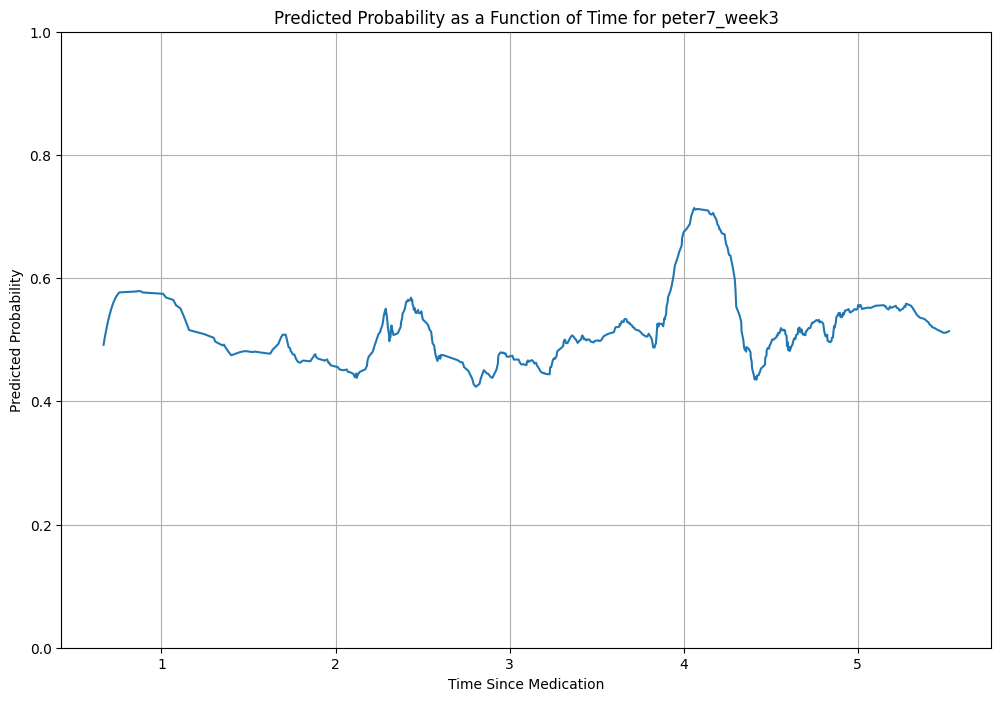

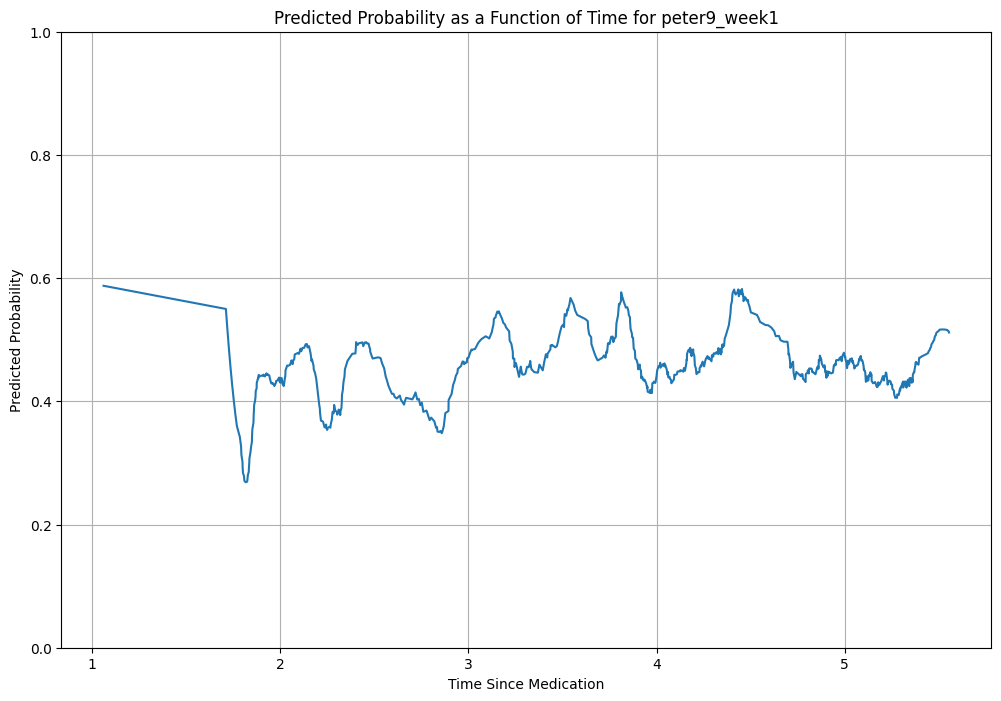

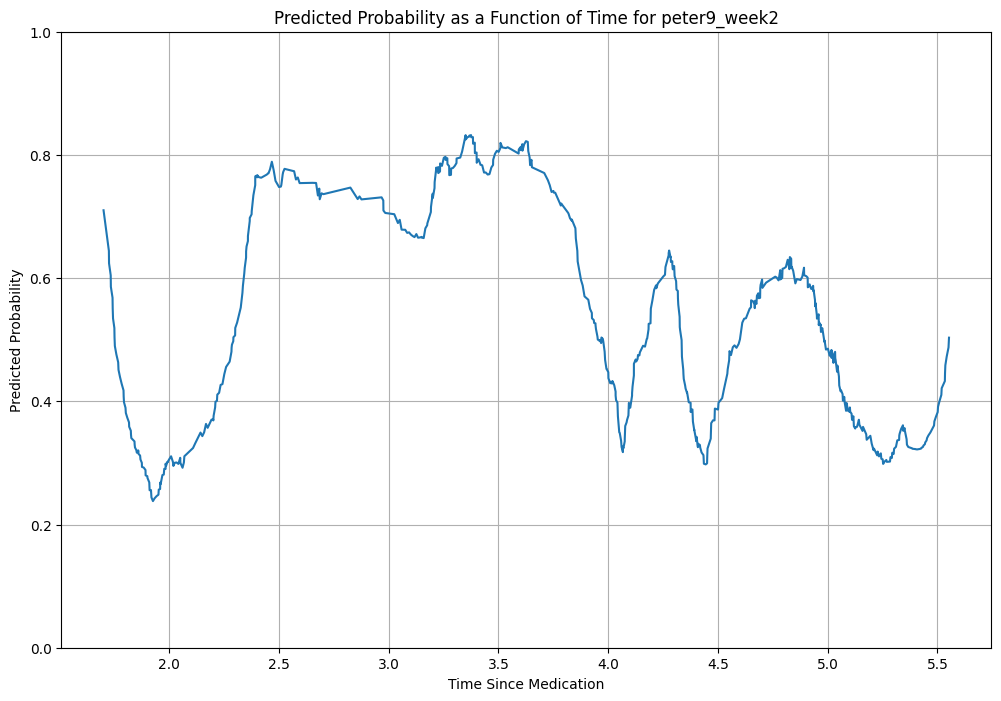

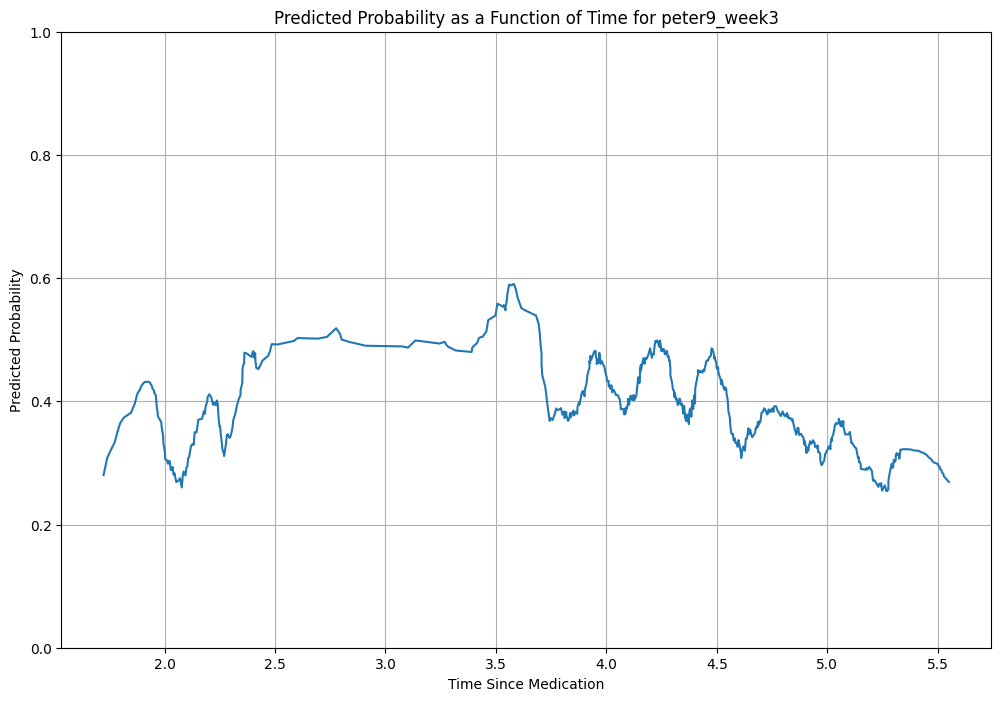

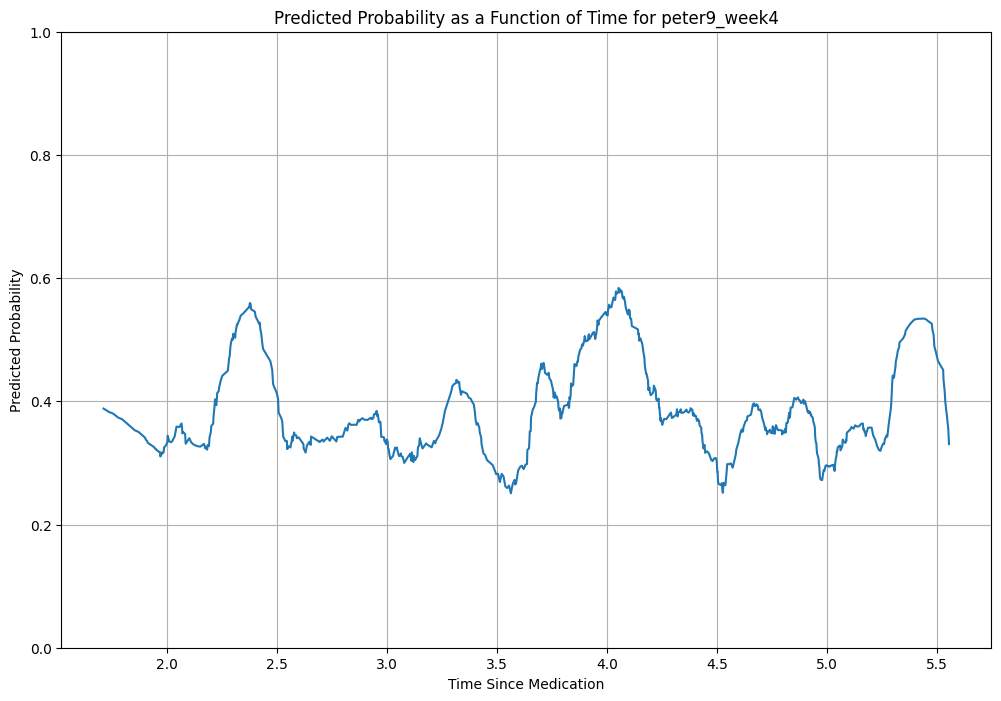

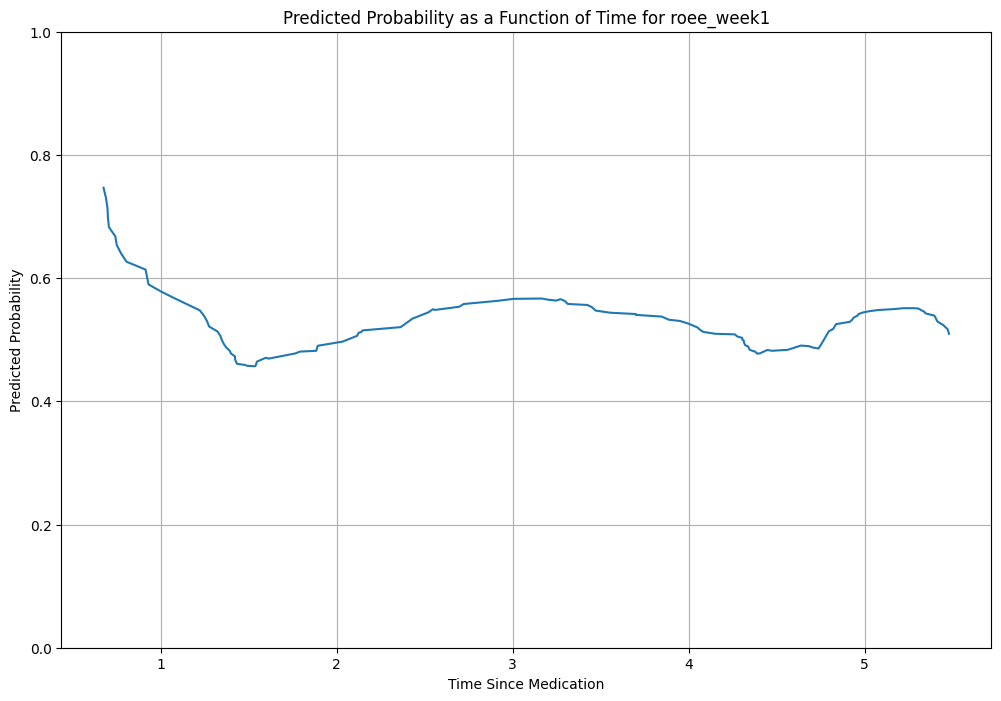

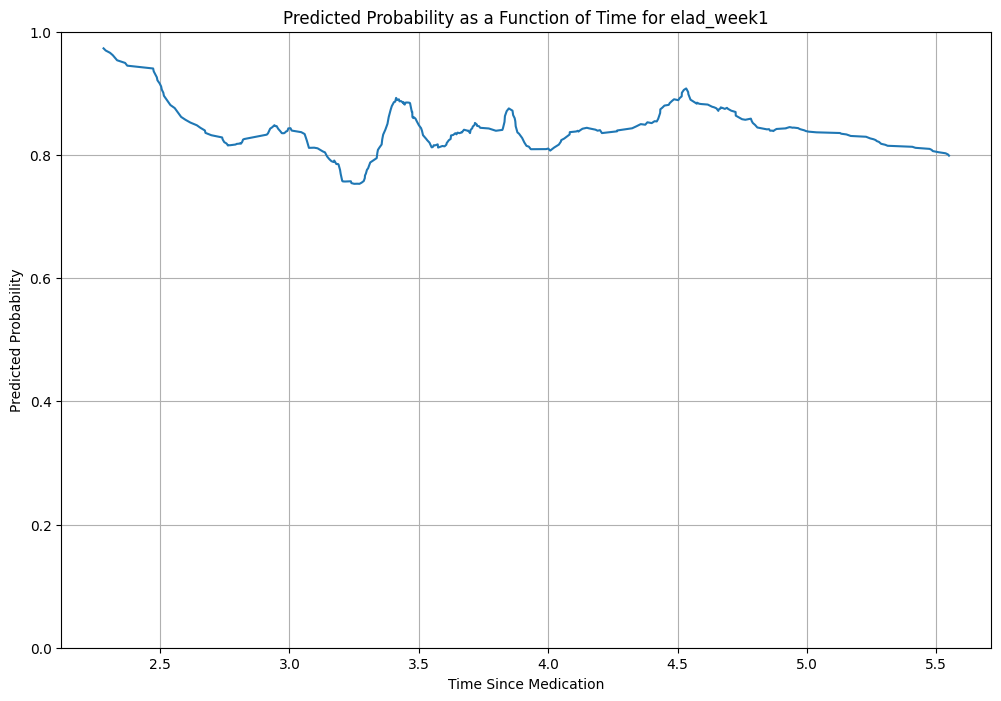

In [1540]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

users = users_daily["user"].unique()

for user in users:
    df_filtered = users_daily[users_daily["user"] == user].sort_values(by='time_since_med')
    x = df_filtered['time_since_med']
    y = df_filtered['predicted_proba']
    plt.figure(figsize=(12, 8))
    y_savgol = savgol_filter(y, window_length=67, polyorder=3)
    plt.plot(x, y_savgol)
    plt.ylim(0, 1)
    plt.xlabel('Time Since Medication')
    plt.ylabel('Predicted Probability')
    plt.title(f'Predicted Probability as a Function of Time for {user}')
    plt.grid(True)
    plt.show()
